# Capture and Processing of Non-Destructive Data Streams
The output results of new non-destructive testing equipment needs to be analyzed over time to determine if process or equipment shifts occur. Process shifts will be detrimental to the company's ability to certify product, and may require additional rework. The project's focus will be on the development of the data-pipeline which can alert if there are process shifts. There are two major types of items that the inspection equipment will be reviewing. The first is production material. Detected flaws must be reacted to both upstream (fixing the cause) and downstream (responding to non-conforming product). The second type of item is a verification piece. The verification piece has known defects in the material of which all need to be found, at approximately the same detection level every time the verification is run. 

The inspection equipment has controlling GUI. The GUI allows for the review of inspection results, but it is not an acceptable platform to perform automated reviews of the data. The GUI executable does expose a socket based API which allows for machine to machine data transfer. Some test result values are compiled by the GUI, and can be retrieved. These results are not representative of all needed parameters which are important to the business operation e.g. (validating the inspection system is healthy). The raw stream data of the tests must also be extracted and processed for statistical characteristics. These characteristics will be tracked over time to look for process shifts. 

The raw data streams and interface have similarities to big data. The communications, analysis, data storage and tracking all need to be developed. These steps will include drawing from multiple data sources (TCP socket API, SQL), and publication of transformed data an SQL database in real time. Basic visualizations for determining process shifts should be included. 

# Required Data To Be Processed
A year ago, the NDT team determined what information will be necessary to capture on the verification rails either as a customer requirement or for process understanding. For the scope of this project, I will be focused on the calibration/verification data rather than product data. The only data available at this time is verification data. The techniques used for determining verification information will be similar to production data. Below is a listing of those requested data.

In [18]:
import pandas as pd
pd.read_csv('target_data_capture.csv')

,Equipment,KPI's to be measured/recorded,Olympus L2 Commands/Events,Data Source
0,Calibration,Calibration inspection number,Set Name (check cal and inspection),JSON/SQL
1,Calibration,Target identifier,Get Calibration Defect,JSON
2,Calibration,target location,Get Calibration Defect,JSON
3,Calibration,Found/Not found,Get Check Calibration Results or Verdict,JSON
4,Calibration,Primary probe used,Get Curve,JSON
5,Calibration,Signal amplitude,Get Check Calibration Results,JSON
6,Calibration,Expected response?,Get Check Calibration Results,JSON
7,Calibration,signal noise level,Get Curve,Stream
8,Calibration,Signal to Noise ratio,Get Curve,Stream
9,Calibration,Calibration rail number,Set Calibration Defect,JSON/SQL


# Import Known Defect Data

In my work flow, I eventually found that I needed to import in the known defect locations for the verification piece. The target locations were documented by the team using a handful of engineering prints. I translated these prints into a numerical tabluar format. Although this step is useful much later on in the process, I'm placing it here, as part of the data collection phase. 

During the later investigations, I determined that the length coordinate of measured values was inverted relative to the print. To compensate for this flipping, I reversed the position coordinates of the "true" position in this excel file. Additionally, I had to do some unit conversion, as the prints were in inches, and the measure values were in millimeters. There was additional meta data describing the defects (size, shape, orientation), but this was scrubbed from the file uploaded to github for confidentiality reasons. The numeric data components remain. 

In [56]:
# Reading target location data from file
target_locations_raw = pd.read_excel('TargetLocations.xlsx')[[
    'inspection_equipment', 
    'channel', 
    'axial_location',
    'offset_distance', 
    'axial_location_reverse_mm', 
    'offset_distance_mm', 
    ]]
target_locations_raw

,inspection_equipment,channel,axial_location,offset_distance,axial_location_reverse_mm,offset_distance_mm
0,UT,NaN,15.0,0.789,6319.012,20.0406
1,UT,NaN,16.0,1.289,6293.612,32.7406
2,UT,NaN,17.0,0.000,6268.212,0.0000
3,EC,IFS1:LT,21.0,1.750,6166.612,44.4500
4,EC,IFB1:LT,21.0,1.750,6166.612,44.4500
...,...,...,...,...,...,...
127,UT,H1-2,36.0,0.000,5785.612,0.0000
128,UT,H1-2,39.0,0.430,5709.412,10.9220
129,UT,H1-1,42.0,0.430,5633.212,10.9220
130,UT,H1-1,45.0,0.000,5557.012,0.0000


When inspecting the measured values later on, I found that there was a lot of variation in the length position value for the same measured target. I need to designate if a found defect correlates to a known target. With this variation in position, I added upper and lower boundaries to target as part of the classification. 

In [57]:
def generate_target_boundaries(df):
    col = 'axial_location_reverse_mm' # Selected target column
    boundary_limit = 100 # variation in mm, this is a rather large variation
    df = df.sort_values(col)
    # Avoiding overlap by knowing other target locations
    shifted = pd.concat(
        [
            df[col], 
            df[col].shift(periods=1, fill_value=0),
            df[col].shift(periods=-1, fill_value=6500)
        ],
        axis=1, 
        keys=['orig', 'pre', 'post']
    )
    # Revising max boundary distance by going no further than 100 mm or average 
    # with the prior coordinate
    df['pre'] = shifted.apply(
        lambda x: x.orig - boundary_limit \
            if (x.orig - x.pre) > boundary_limit \
            else (x.orig + x.pre)/2,
        axis=1
    )
    # Revising max boundary distance by going no further than 100 mm or average 
    # with the next coordinate
    df['post'] = shifted.apply(
        lambda x: x.orig + boundary_limit \
            if (x.post -x.orig) > boundary_limit \
            else (x.orig + x.post)/2,
        axis=1
    )

    return df

# Apply new limits for each channel separately.
target_locations = (
    target_locations_raw
    .groupby('channel')
    .apply(generate_target_boundaries)
    .drop(columns='channel') # 'channel' column gets duplicated during apply 
)

target_locations.index.set_names(['channel', 'sequence'], inplace=True)
target_locations

inspection_equipment  axial_location  offset_distance  \
channel sequence                                                         
:OB     99                         EC           226.5            0.000   
        91                         EC           213.0              NaN   
B1:BR-1 35                         UT            87.0              NaN   
        30                         UT            79.0            0.625   
        27                         UT            76.0            0.000   
...                               ...             ...              ...   
W2:ST-1 40                         UT            93.0            3.250   
        41                         UT            93.0            4.030   
        36                         UT            90.0            2.470   
        37                         UT            90.0            3.250   
        38                         UT            90.0            4.030   

                  axial_location_reverse_mm  offset_distance_mm       pre  \
channel sequence                                                            
:OB     99                          946.912               0.000   846.912   
        91                         1289.812               0.000  1189.812   
B1:BR-1 35                         4490.212               0.000  4390.212   
        30                         4693.412              15.875  4593.412   
        27                         4769.612               0.000  4731.512   
...                                     ...                 ...       ...   
W2:ST-1 40                         4337.812              82.550  4337.812   
        41                         4337.812             102.362  4337.812   
        36                         4414.012              62.738  4375.912   
        37                         4414.012              82.550  4414.012   
        38                         4414.012             102.362  4414.012   

                      post  
channel sequence            
:OB     99        1046.912  
        91        1389.812  
B1:BR-1 35        4590.212  
        30        4731.512  
        27        4807.712  
...                    ...  
W2:ST-1 40        4337.812  
        41        4375.912  
        36        4414.012  
        37        4414.012  
        38        4514.012  

[122 rows x 7 columns]

With this data frame, I have the target's characteristics and a reasonable boundary to determine if a found defect is a false positive, or related to an intentional defect.

# Configuring Test Equipment Database
The test database for the equipment was provided by the vendor as a backup of a MS SQL server database. It was generated as part of a factory acceptance test, validating equipment functionality. It contains scans from a verification piece; detected flaws should be consistent. 

The database was version 15 (Server 2019). The only offline databases at the office I had write permissions to was an earlier version, so I was unable to upload the newer version to it due to version incompatibility. 

I explored an alternate method of creating a Windows 10 virtual machine on my desktop and installing the latest version of SQL server express on it. Although it did work, the needed networking configuration to communicate with the other source databases was complicated by IT network policies.

After some additional research, I discovered MS SQL local database. After installing the SQL kernel, I was able to create a local only database which is suitable for small application development. The SQL database connection is exposed via a local host network pipe protocol. Once connected using the network pipe, the SQL server acts ;ike a full SQL server. This is an interesting alternative to a SQLite database for small applications. One of the more annoying aspects of using this solution is that every instance of the database, once closed, changes its pipe path. 

I wrote a function in Python to run the windows executable and capture the STDOUT and extract the pipe path so it could be passed as the host for a connection string. This connection string is used by both the python script, and by the inspection software which supplies the API used later. 

In [47]:
# start the local database, and return the connection database. 
def start_local_test_db(db_name='EvidentTestDB'):
    """
    Starts local database instance if it isn't running yet
    db_name: str target database name
    Returns:
    host: str host pipe path for connection
    """
    import subprocess
    import re
    sqllocaldb = r"C:\Program Files\Microsoft SQL Server\160\Tools\Binn\SqlLocalDB.exe" 
    response = subprocess.run(
        [sqllocaldb,'info', db_name], 
        stdout=subprocess.PIPE
    )
    
    if "Stopped" in response.stdout.decode('utf-8'): # Start DB
        subprocess.run([sqllocaldb,'start', db_name])
        response = subprocess.run(
            [sqllocaldb,'info', db_name], 
            stdout=subprocess.PIPE
        )
    elif 'doesn\'t exist' in response.stdout.decode('utf-8'):
        raise ValueError(f'Database {db_name} doesn\'t exist.')
    return re.search(r'\\\\.\\pipe\\LOCALDB#........\\tsql\\query', response.stdout.decode('utf-8'))[0]
ndt_host = start_local_test_db()
ndt_host

'\\\\.\\pipe\\LOCALDB#A4C967E8\\tsql\\query'

## Establish Connection to Local Database
Because of the sensitive nature of connection strings to company servers which include passwords, I import connection strings from an external file. This file is saved locally, and will not get uploaded to the github repository. The connection string sqlalchemy compatible.

I have three methods to connect to the database; two methods will provide raw data in tabular format e.g. using python/pandas/sqlalchemy or jupyter notebook sql direct connection . The third is using an API interaction with the inspection system GUI. The API both receives and sends data in JSON format. Stream data is sent over a separate port. 

When connecting in any method, the connection string needs to be established.

In [20]:
import pandas as pd
from sqlalchemy import create_engine, text
from connections import get_tracking_connection_str, get_ndt_connection_str

# jupyter notebook extension to run in line sql using ipython-sql
%load_ext sql

ndt_connection_str = get_ndt_connection_str(host=ndt_host)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Below is a demonstration of using `pandas` to connect to the database. At the start of this practicum, SQLAlchemy went through a revision update and changed its connection methodology, which required pandas to connect using connection engine instead of the previously accepted method of using a pure connection string. This functionality may return in future versions of `pandas`.

In [21]:
# Create connection engine
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
# Gather requested data
output = pd.read_sql(text('SELECT * from Batch;'), connection)
# Close connection engine
connection.close()
output

,BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
0,26,1,Test systeme,2022-03-28,2022-03-28,,,,,,,6,,,,,
1,27,2,Repetabilite,2022-03-28,2022-03-28,,,,,,,6,,,,,


Alternatively, this is the method to connect to the database using the in-line sql call. Prior to this project, I wasn't aware of this functionality.

In [22]:
# Tips on how to perform inline SQL found at
# https://www.sqlshack.com/learn-jupyter-notebooks-for-sql-server/

%sql $ndt_connection_str
%sql SELECT * from Batch;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


BatchIndex,OrderListNumber,Name,StartDate,EndDate,SteelType,Documents,Area,Thermal,FlowNumber,Customer,FK_B_OrderIndex,ProductDimension,ControlSpecification,OperatorName,Equipment,ProductPrefix
26,1,Test systeme,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,
27,2,Repetabilite,2022-03-28 00:00:00,2022-03-28 00:00:00,,,,,,,6,,,,,


# Exploring The Database Schema
Now that there is a functional connection established to the database, I can begin to explore the data contained within. First, I will look at the database schema to look for the most important tables and how they are connected together. Second, I will be looking at the API documentation to determine the best way to get the needed data out of the database. I expect the final solution will be a combination of the two data retrieval methods.

Using MSSQL's built in schema structure tables, I can see that there are 110 tables in this database. 

In [23]:
# Print table characteristics in database
%sql SELECT * FROM INFORMATION_SCHEMA.TABLES ORDER BY TABLE_NAME;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
EvrazL2Test,dbo,AlarmFilter,BASE TABLE
EvrazL2Test,dbo,AlarmFilterSetup,BASE TABLE
EvrazL2Test,dbo,AlarmInfoEC,BASE TABLE
EvrazL2Test,dbo,AppSetting,BASE TABLE
EvrazL2Test,dbo,Batch,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldTemplate,BASE TABLE
EvrazL2Test,dbo,BatchCustomFieldValue,BASE TABLE
EvrazL2Test,dbo,BatchEC,BASE TABLE
EvrazL2Test,dbo,BatchUT,BASE TABLE
EvrazL2Test,dbo,BenchInfo,BASE TABLE


I did some exploration of individual table schemas such as the structure of the `Batch` table, previously presented. 

In [25]:
# Getting the individual table column schema data from the batch table
%%sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
WHERE tab.name like 'Batch'
ORDER BY schema_name, table_name, column_id;

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


schema_name,table_name,column_id,column_name,data_type,max_length,precision
dbo,Batch,1,BatchIndex,int,4,10
dbo,Batch,2,OrderListNumber,int,4,10
dbo,Batch,3,Name,nvarchar,200,0
dbo,Batch,4,StartDate,datetime,8,23
dbo,Batch,5,EndDate,datetime,8,23
dbo,Batch,6,SteelType,nvarchar,100,0
dbo,Batch,7,Documents,nvarchar,100,0
dbo,Batch,8,Area,nvarchar,100,0
dbo,Batch,9,Thermal,nvarchar,100,0
dbo,Batch,10,FlowNumber,nvarchar,100,0


The most useful part of this exercise is understanding the vendor's table and index name scheme. Their foreign keys are 'FK_\<abbreviation of current db\>_<connectedDB\>Index'. With this systematic approach in mind, I grabbed all of the columns in the database as a single DataFrame.

In [26]:
# Getting the whole database schema into a single dataframe
sql = '''--begin-sql
SELECT schema_name(tab.schema_id) AS schema_name,
    tab.name as table_name, 
    col.column_id,
    col.name as column_name, 
    t.name as data_type,
    col.max_length,
    col.precision
FROM sys.tables as tab
    INNER JOIN sys.columns as col
        on tab.object_id = col.object_id
    LEFT JOIN sys.types as t
    on col.user_type_id = t.user_type_id
ORDER BY schema_name, table_name, column_id;
--end-sql
'''
engine = create_engine(ndt_connection_str)
connection = engine.connect() #must close this at some point
table_schema = pd.read_sql(text(sql), connection)
connection.close()
table_schema

,schema_name,table_name,column_id,column_name,data_type,max_length,precision
0,dbo,AlarmFilter,1,AlarmFilterIndex,int,4,10
1,dbo,AlarmFilter,2,APDFilter,int,4,10
2,dbo,AlarmFilter,3,RPDFilter,int,4,10
3,dbo,AlarmFilter,4,FK_AF_ModeIndex,int,4,10
4,dbo,AlarmFilter,5,GateID,tinyint,1,3
...,...,...,...,...,...,...,...
1081,dbo,WTRAlarm,6,WTRemaining,int,4,10
1082,dbo,WTRAlarm,7,WTValue,int,4,10
1083,dbo,WTRAlarm,8,DefectDepth,int,4,10
1084,dbo,WTRAlarm,9,EntryDate,datetime,8,23


## Diagramming NDT Database
I found an online database diagraming software, http://dbdiagram.io. The site uses a simple syntax to build database diagrams. Below is the code that formats 95% of the table structures from the schema dataframe into a text file which is compatible with the website. I had to correct 5% by hand in order to deal with some naming convention inconsistencies. The final uploadable diagram script is at [data diagram](dbdiagram_all.txt). There are nearly 110 tables and 1100 columns in the database. Going through the whole diagram is difficult, but visualizing some of the relationships could be important later on.

In [27]:
def form_table(f, table_name, df):
    f.write('Table %s {\n' % table_name) # Write table name
    for row in df.itertuples(index=False, name='Field'):
        if row.column_name.startswith('FK'): # handle foreign key links
            ref_col = row.column_name.split('_')[-1] # last split is foreign table
            ref_table = ref_col[:-5] # remove "INDEX" text
            ref = f"[ref: > {ref_table}.{ref_col}]" # Reformat linking syntax for website
        else: 
            ref='' # if no link, make it an empty string
        f.write(f'  {row.column_name} {row.data_type} {ref}\n') # write column to line
    f.write('}\n\n') # table closure syntax

with open('dbdiagram_raw.txt', 'w') as f: # Open the file
    for table_name, df in table_schema.groupby('table_name'): # group by table
        form_table(f, table_name, df)

When built, the auto generated database diagram is extensive. For this reason, I will try to use the API as much as possible to get the desired data. Eventually I'm sure I will need to revisit the schema.

![ERD](dbdiagram_all.png)

# Direct SQL Downloads
## Obtain Channel IDs
After reviewing the available API functions, I found that the linking between the channel numbers (needed for several functions) and their designation or names (human readable format) did not exist. To get this data I need to query directly from the database. The channels are the individual probes used to scan the material. 

In [28]:
# Channel Characteristics
channel_characteristics_ut = %sql SELECT * FROM [dbo].[Channel];
channel_characteristics_ec = %sql SELECT * FROM [dbo].[ChannelEC];

# Convert to DataFrames
channel_characteristics_ut = pd.DataFrame(channel_characteristics_ut)
channel_characteristics_ec = pd.DataFrame(channel_characteristics_ec)

# Join all channels together into a single frame
channel_names = pd.concat([
    (
        channel_characteristics_ut[
            ['ChannelID', 'Name']
        ]
        .drop_duplicates()
    ),
    (
        channel_characteristics_ec
        [['ChannelECID', 'Name']]
        .drop_duplicates()
        .rename(columns={'ChannelECID': 'ChannelID'})
    )],
    axis=0,
    keys=['UT', 'EC']
).droplevel(-1).set_index('ChannelID', append=True)
channel_names.index.set_names(['Type', 'ChannelID'], inplace=True)
channel_names

 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.
 * mssql+pyodbc://sa:***@\\.\pipe\LOCALDB#35A98E3F\tsql\query/EvrazL2Test?Encrypt=no&driver=ODBC+Driver+18+for+SQL+Server
Done.


Name
   ChannelID          
UT 0              H1-1
   1000             H1
   11            B2:ST
   8           W2:ST-3
   5             W1:ST
   2                H2
   10            B1:BR
   7           W2:ST-2
   4            HS2:ST
   1              H1-2
   1001          W2:ST
   9           W2:ST-4
   6           W2:ST-1
   3            HS1:BR
EC 1          CHRS1:LT
   2          CHRS1:OB
   3          CHRB1:LT
   4          CHRB1:OB
   5           SHS1:LT
   6           SHS1:OB
   7           SHB1:LT
   8           SHB1:OB
   11          IFS1:LT
   12          IFS1:OB
   13          FES1:LT
   14          FES1:OB
   15           BS1:LT
   16           BS1:OB
   19          IFB1:LT
   20          IFB1:OB
   21          FEB1:LT
   22          FEB1:OB
   23           BB1:LT
   24           BB1:OB

# API Interaction
The vendor provided a simple pyqt based GUI to demonstrate API connection protocols and accessor functions. I dug through the source code to understand what components are necessary for communication. Borrowing these concepts, and core components, I will create my own functions which pull requested data (in an non-GUI) format. 

At the core, the ZeroMQ (`zmq`) library is used for TCP socket communications. The vendor provided wrapper classes in [ZMQClient](ZMQClient.py) which I will use for sending and receiving data. These classes wrap certain required values and simplify the overall sending and receiving commands. The API host is local on this machine, and as previously stated, uses different ports for different communication types. I need to establish the connection client objects using what was provided by the vendor. 

## Connection to API Host
Common conversions between values are written in [globals.py](globals.py). The database saves a lot of data as enumerated values. The globals dictionaries can be used to convert back and forth.

In [29]:
# Establish clients to connect to the API host
import ZMQClient # The local module
from globals import * # Global conversions for enumerated values

SYSTEM = 1

server_ip = '127.0.0.1'

client = ZMQClient.ZMQCommandClient(server_ip, 7600)
event_client = ZMQClient.ZMQEventClient(server_ip, 7601)
data_client= ZMQClient.ZMQDataClient(server_ip, 7602)

## Product List by Type
This code block retrieves all of the available products which have been loaded. The type is either ultrasonic or eddy current. Only one product for each type is used for the remainder of data requests. 

In [30]:
# Get Product List By Type
products = {}
for key, value in TECHNOLOGY.items():
    if isinstance(key, str):
        json_response = client.sendCommand(
            'get_product_list_by_type', {
                'type': value
            }
        )
        products[key] = json_response['product_types']
products

{'UT': ['ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_test web',
  'ris_141-ALT_Rail 141 Test sonde mono',
  'ris_141-ALT_Rail 141 ProveUp Perpendicular',
  'ris_141-ALT_test web Perpendicular',
  'ris_141-ALT_Rail 141 Test master gauge',
  'ris_141-ALT_Rail 141 Test uni QV',
  'ris_141-ALT'],
 'EC': ['ris_115_Rail 115 Prove Up',
  'ris_115_Rail 115 Test EC',
  'ris_115_Rail 115 Test EC 25 PSI',
  'ris_115_Rail 115 Prove Up Inverse',
  'ris_115_Rail 115 Test silent bloc',
  'ris_115_Rail 115 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC',
  'ris_136-ALT-4_Rail 136 ProveUp Nouveau Patin EC Base modifie',
  'ris_141-ALT_Rail 141 ProveUp',
  'ris_141-ALT_Rail 141 ProveUp 15Psi',
  'ris_141-ALT']}

## Order List
Separate orders are used to differentiate product changes, and other specification requirement changes. There were only two orders on the database, because this is test data. The second order I accidentally created trying to navigate the GUI system. I filtered to just the one relevant order.

In [31]:
# Get Order List
def get_order_list():
    json_response = client.sendCommand(
        'get_order_list', {
        }
    )
    return json_response['orders']

order = get_order_list()[0]
order

'RAIL 136 PROVE UP FINAL'

## Batch List
Batches are a subset to an order, indicating a specific run of the same material or heat number. It can be used to group inspections by time stamps. The batch list is a listing of all batches applied to an order.

In [32]:
# Get Batch List
def get_batch_list(order):
    json_response = client.sendCommand(
        'get_batch_list', {
            'order': order
        }
    )
    return json_response['batches']

batches = get_batch_list(order)
batches

['Test systeme', 'Repetabilite']

## Batch Info
This function gets batch details from the database, including the inspection plans, and piece characteristics.

In [33]:
# Get Batch Info
def get_batch_info(order, batch):
    json_response = client.sendCommand(
        'get_batch_info', {
            'order': order,
            'batch': batch
        }
    )
    return json_response['batch_info']
get_batch_info(order, batches[0])

{'area': '',
 'batch_id': 26,
 'control_specification': '',
 'customer_name': '',
 'default_setup_ec': 'Evraz EC Prove Up_ris_136-ALT-4_Rail 136 ProveUp.set',
 'default_setup_ec_id': 9,
 'default_setup_ut': 'Evraz UT Prove Up_ris_136-ALT-4_Rail 136 ProveUp_0_2.acq',
 'default_setup_ut_id': 17,
 'end_date': '3/20/2023',
 'file_number': '',
 'grade': '',
 'heat': '',
 'nuance_of_steel': '',
 'operator_name': '',
 'product_dimension': '',
 'product_type_ec': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ec_id': 8,
 'product_type_ut': 'ris_136-ALT-4_Rail 136 ProveUp',
 'product_type_ut_id': 4,
 'start_date': '3/28/2022'}

## Product Piece List
This function returns a list of the piece identifiers for a given order and batch, with some additional characteristics.

In [34]:
# Get Product Piece List
def get_rail_list(order, batch, check_calibration=False):
    json_response = client.sendCommand(
        'get_tube_list', {
            'order': order,
            'batch': batch,
            'check_calibration': check_calibration
        }
    )
    return json_response['tubes']
rail_list = get_rail_list(order, batches[0])
print(f"Number of rails in batch '{batches[0]}': {len(rail_list)}")
rail_list[:2]

Number of rails in batch 'Test systeme': 45


[{'db_index': 2366,
  'inspection_date': '6/1/2022 1:36:10 PM',
  'judgement': 2,
  'length': 6734249,
  'name': 'Rail 1',
  'order_list_number': 1,
  'scan_number': 1,
  'start': 0},
 {'db_index': 2367,
  'inspection_date': '6/1/2022 1:37:17 PM',
  'judgement': 2,
  'length': 6722800,
  'name': 'Rail 2',
  'order_list_number': 2,
  'scan_number': 1,
  'start': 0}]

## Curve Data
The equipment manufacturer differentiates actual inspections by curve data and stream data. The curve data is the descriptor information to identify the characteristics associated with an inspection. The stream data is the characteristics associated with the real-time inspection values from the sensor. The response from the API server packages both together. 

This code block gets curve data, and reformats it as a MultiIndex DataFrame. The major column splitter is descriptor data or stream data. Using the global data imported earlier, human readable values are applied as separate columns to the enumerated columns.

In [35]:
# Get Curve
def get_curves(
        rail_index,
        channel=-1,
        gate=0,
        data=0,
        mode=0,
        group=0,
        check_cal=False,
):
    json_response =  client.sendCommand(
        'get_curve', {
            'system_id': SYSTEM,
            'tube_id' : rail_index,
            'channel_id': channel,
            'mode_id' : mode,
            'group_type' : group,
            'gate_id' : gate,
            'data_type': data,
            'check_calibration': check_cal
            }
        )
    for curve in json_response['curves']:
        curve['descriptor']['rail_index'] = curve['descriptor'].pop('tube_id')
        curve['stream']['rail_index'] = curve['stream'].pop('tube_id')
    return json_response['curves']

display_order = [ # set display order
    'system_id',
    'rail_index',
    #'ec',
    'mode',
    'group',
    'data_type',
    'gate_id',
    'channel_id',
    'channel_name',
    'data_min',
    'data_max',
    'data_qty',
    'index_qty',
    'index_res',
    'index_start_offset',
    'index_first_valid_point',
    'scan_qty',
    'scan_res',
    'inspection_direction',
    'product_length',
    'orientation',
]

def curves_to_frame(curves):
    descriptor = []
    stream = []
    for curve in curves: # split the response into descriptors and stream information
        descriptor.append(curve['descriptor'])
        stream.append(curve['stream'])
    # Clean up the descriptor data first
    descriptor_df = pd.DataFrame.from_dict(descriptor) # Make an initial data frame
    descriptor_df = (
        descriptor_df
        .assign( # Create new columns by mapping global values
            mode=descriptor_df['mode_id'].map(MODE),
            group=descriptor_df['group_type'].map(GROUP_TYPE),
        ) # Replace columns by mapping global values
        .replace({
            'inspection_direction': INSPECTION_DIRECTION,
            'orientation': ORIENTATION,
            'data_type': DATA_TYPE
            }
        )
        .rename(columns={'name': 'channel_name'})
        [display_order] # set the return column order
    )
    # Convert the stream data. No additional clean up required.
    stream_df = pd.DataFrame.from_dict(stream)
    return (
        pd.concat( # Join both data sets together
            [descriptor_df, stream_df],
            axis=1,
            keys=['Descriptor', 'Stream']
        )
    )

curve_df = curves_to_frame(get_curves(2366))
curve_df['Descriptor'].head()

,system_id,rail_index,mode,group,data_type,gate_id,channel_id,channel_name,data_min,data_max,data_qty,index_qty,index_res,index_start_offset,index_first_valid_point,scan_qty,scan_res,inspection_direction,product_length,orientation
0,1,2366,Head,Normal,Amplitude,1,2,H2,0,0,1,2693,2500,0,0,1,1000,Normal,6734249,All
1,1,2366,Head,Normal,Amplitude,2,2,H2,0,0,1,2693,2500,0,0,1,1000,Normal,6734249,All
2,1,2366,Head Side,Normal,Amplitude,1,3,HS1:BR,0,0,1,2405,2800,0,0,8,2200,Normal,6734249,BR
3,1,2366,Head Side,Normal,Amplitude,1,4,HS2:ST,0,0,1,2405,2800,0,0,8,2200,Normal,6734249,ST
4,1,2366,Web,Normal,Amplitude,1,5,W1:ST,0,0,1,2993,2250,0,0,5,2000,Normal,6734249,ST


In [36]:
curve_df['Stream'].head()

,data_size,length,stream_id,system_id,rail_index
0,1,2693,0,1,2366
1,1,2693,1,1,2366
2,1,19240,2,1,2366
3,1,19240,3,1,2366
4,1,14965,4,1,2366


## Stream Data
Actual stream data from the sensors can be retrieved using the stream ID and size from the get curve data return. The data can be converted to a Series and manipulated, including plotting.

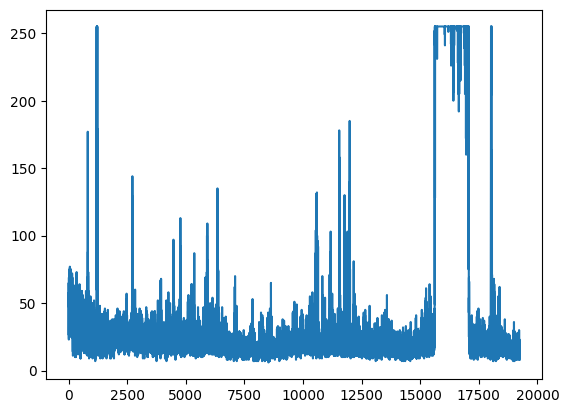

In [37]:
# Get Streams
def get_stream(
        rail_index,
        stream_id,
        length,
        data_size,
        data_position=0,
        system_id=SYSTEM,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_stream', {
            'streams': [{
                'system_id': system_id,
                'tube_id': rail_index,
                'stream_id': stream_id,
                'length': length,
                'data_size' : data_size,
                'data_position': data_position,
            }]
        }
    )
    # If there is data, retrieve it from the other port
    if json_response['streams'][0]['status']:
        stream_data = data_client.receiveData()
        return list(bytearray(stream_data))
    else:
        raise TypeError(f'Retrieval of stream_id {stream_id} failed.')

stream = pd.Series(get_stream(**get_curves(2366)[3]['stream']))
stream.plot();

## Processing Signal to Noise Ratio
One of the objectives for this project for the business case is to be able to perform additional analysis which is not obtainable using the API aggregated information directly. By getting to the raw stream data additional features could be extracted which are important to overall understanding of the defects detected. One of these characteristics is the signal to noise ratio. 

In [38]:
def stream_stats(stream):
    if isinstance(stream, list):
        stream = pd.Series(stream)
    # 80% common threshold to differentiate signal and noise
    threshold = 0.8 * stream.max() 
    signal_pts = stream.where(stream > threshold)
    noise_pts = stream.where(stream <= threshold)

    signal_lvl = pd.Series(signal_pts.mean(), index=['Signal'])
    noise_lvl = pd.Series(noise_pts.median(), index=['Noise'])
    signal_noise = pd.Series(
        signal_lvl.loc['Signal'] / noise_lvl.loc['Noise'],
        index=['SNR']
    )
    
    return pd.concat([signal_lvl, noise_lvl, signal_noise])

stream_stats(stream)


Signal    254.282565
Noise      19.000000
SNR        13.383293
dtype: float64

Visualizing the different parts of the signal to noise calculation. This includes the signal data (red), the noise data (blue) the threshold value (gree) and the median of the noise (orange).

<AxesSubplot: >

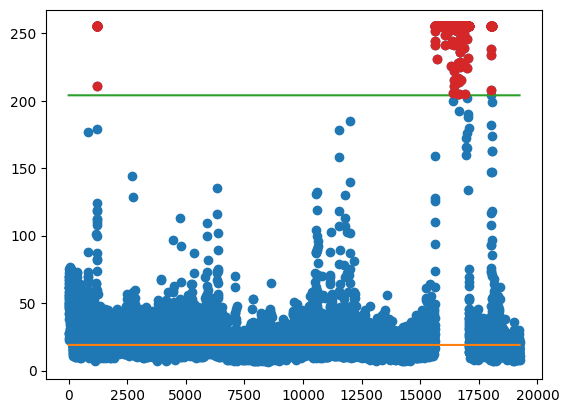

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)

threshold = .8 * max(stream)
signal = stream.where(stream> threshold)
noise = stream.where(stream<=threshold)

stream.plot(ax=ax, style='o')
pd.Series(noise.median(), index=stream.index).plot(ax=ax)
pd.Series(threshold, index=stream.index).plot(ax=ax)
signal.plot(ax=ax, style='o');


# !!!!!_*EXTRACT SNR from all  AND UPLOAD TO TABLE*_
Using several for loops, 

## Defect Extractions
The equipment manufacturer has built in routines to determine and perform some characterization of defects. These values are logged for each piece scanned. There is a 1D and 2D scan for ultrasonic results. The 2D results do not appear to have been loaded into the the database, so only 1D is available. Being only 1D, I suspect the defects detected are values which meet a minimum threshold, and the distance along the length of the piece. 

I pull the defect data, and convert it to a DataFrame for further analysis.

In [40]:
# Get Defects 1D UT
def get_defects_1d_ut(
        rail_index,
        system_id=SYSTEM,
        merge_type=0,
        merge_gates=False,
        **kwargs
):
    if (merge_type in range(1, 4)) and merge_gates:
        raise ValueError('Merge Gates only compatible with merge type `Global`(0)')

    json_response =  client.sendCommand(
        'get_defects_ut', {
            'tube_id': rail_index,
            'system_id': system_id,
            'merge_type': merge_type,
            'merge_gates': merge_gates,
        }
    )
    return json_response['defects']

def defects_1d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
        .assign( # Create new columns by mapping global values
            mode=descriptor_df['mode_id'].map(MODE),
        )
    )

defect_1d_ut_df = defects_1d_ut_to_frame(get_defects_1d_ut(2366))
print(defect_1d_ut_df.info())
defect_1d_ut_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alarm_id         433 non-null    int64  
 1   axial_length     433 non-null    float64
 2   axial_position   433 non-null    float64
 3   channel_id       433 non-null    int64  
 4   gate_id          433 non-null    int64  
 5   group_id         433 non-null    int64  
 6   mode_id          433 non-null    int64  
 7   radial_length    433 non-null    float64
 8   radial_position  433 non-null    float64
 9   submode_id       433 non-null    int64  
 10  channel_name     433 non-null    object 
dtypes: float64(4), int64(6), object(1)
memory usage: 37.3+ KB
None


,alarm_id,axial_length,axial_position,channel_id,gate_id,group_id,mode_id,radial_length,radial_position,submode_id,channel_name
0,1,5.6,11.200,3,1,0,11,0.0,0.0,1,HS1:BR
1,1,2.8,238.000,3,1,0,11,0.0,0.0,1,HS1:BR
2,1,2.8,282.800,4,1,0,11,0.0,0.0,2,HS2:ST
3,1,7.5,367.500,2,2,0,10,0.0,0.0,0,H2
4,1,9.6,374.399,1000,1,0,10,0.0,0.0,0,H1


In [41]:
# Get Defects 2D UT; currently no data available
def get_defects_2d_ut(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ut', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

def defects_2d_ut_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .join(channel_names.loc['UT'], on='channel_id')
        .rename(columns={'Name': 'channel_name'})
    )
get_defects_2d_ut(2366)
#defect_2d_ut_df = defects_2d_ut_to_frame(get_defects_2d_ut(2366))
#print(defect_2d_ut_df.info())
#defect_2d_ut_df.head()

[]

Regarding Eddy Current, only 2D results are available. This code block also performs some additional manipulation to identifying the locations of the defects in 2D space. The raw data provides the corner coordinates of the defects, and splitting these into four separate columns is more useful.

In [42]:
# Get Defects 2D EC
def get_defects_2d_ec(
        rail_index,
        **kwargs
):
    json_response =  client.sendCommand(
        'get_defects_2d_ec', {
            'tube_id': rail_index,
        }
    )
    return json_response['defects']

# Converting to a DataFrame
def defects_2d_ec_to_frame(defects):
    return (
        pd.DataFrame(defects)
        .drop(columns='coords') # Remove the coordinates for simplicity
        .join(channel_names.loc['EC'], on='channel_id')
        .replace({'data_type': DATA_TYPE})
        .rename(columns={'Name': 'channel_name'})
    )

# Handle convert the x, y coordinate points to DataFrame
def defects_2d_coordinates_corners(defects):
    idx = ['bottom left', 'top left', 'top right', 'bottom right']
    df_l = [pd.DataFrame(defect['coords'], index=idx) for defect in defects]
    return pd.concat(df_l, keys=range(len(defects)))

# Converting x, y points to just side extents
def defects_2d_coordinates_extents(defects):
    cols = ['top', 'left', 'bottom', 'right']

    df_l = [(
        defect['coords'][1]['y'], #top
        defect['coords'][1]['x'], #left
        defect['coords'][3]['y'], #bottom
        defect['coords'][3]['x'], #right
        ) for defect in defects]
    return pd.DataFrame.from_records(df_l, columns=cols)

#def defects
defect_2d_ec_df = defects_2d_ec_to_frame(get_defects_2d_ec(2366))
print(defect_2d_ec_df.info())
defect_2d_ec_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alarm_id      345 non-null    int64  
 1   amplitude     345 non-null    float64
 2   channel_id    345 non-null    int64  
 3   data_type     345 non-null    object 
 4   group_id      345 non-null    int64  
 5   channel_name  345 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 16.3+ KB
None


,alarm_id,amplitude,channel_id,data_type,group_id,channel_name
0,1,-2.36,1,All,1,CHRS1:LT
1,1,4.14,1,All,1,CHRS1:LT
2,1,2.78,1,All,1,CHRS1:LT
3,1,-2.01,1,All,1,CHRS1:LT
4,1,-5.00,1,All,1,CHRS1:LT


The coordinate data can be split into a DataFrame representing 1 item to the four (many) corner coordinates. 

In [44]:
defects_2d_coordinates_corners(get_defects_2d_ec(2366)).head(10)

x     y
0 bottom left   437.0  60.0
  top left      437.0  64.0
  top right     440.0  64.0
  bottom right  440.0  60.0
1 bottom left   441.0  64.0
  top left      441.0  68.0
  top right     446.0  68.0
  bottom right  446.0  64.0
2 bottom left   442.0  55.0
  top left      442.0  59.0

The data will be more usable by understanding the extents of the defect, and this provides a single record for each rail instead of a one to many relationship. 

In [86]:
defects_2d_coordinates_extents(get_defects_2d_ec(2366)).head(10)

,top,left,bottom,right
0,64.0,437.0,60.0,440.0
1,68.0,441.0,64.0,446.0
2,59.0,442.0,55.0,446.0
3,64.0,449.0,60.0,450.0
4,68.0,539.0,21.0,550.0
5,64.0,851.0,60.0,855.0
6,64.0,1072.0,60.0,1086.0
7,42.0,2073.0,34.0,2078.0
8,38.0,2528.0,34.0,2537.0
9,67.0,2983.0,55.0,2988.0


The last function from the API is to get calibration defects. This is currently either not implemented by the API or no matching data was uploaded to the test database.

In [79]:
# Get calibration defects, currently not operational in API
#def get_setup_calibration_defects_ut(
#    calibration_product,
#    setup_id,
#    system_id=0,
#):
#    json_response = client.sendCommand(
#        'get_setup_calibration_defects_ut', {
#            'system_id': system_id,
#            'calibration_product': calibration_product,
#            'setup_id': setup_id
#        }
#    )
#    return json_response['defects']
#
#cal_defects = get_setup_calibration_defects_ut('Rail 136 Prove Up', 27)
#cal_defects

# Extract Defect Data
The previously defined API functions allowed for the extraction of small data subsets from the test database. To do a review of all of the tests performed, I have to iterate over all of the rails and combine into a single DataFrame for each type of test. First I will start at the top, and get all of the orders in the database.

In [45]:
# Get all Orders
orders = get_order_list()
orders

['RAIL 136 PROVE UP FINAL', 'ORDER TEST']

From the order list, I need to get a full list of batches. As I mentioned earlier, the "ORDER TEST" was generated by me interacting with the GUI. No related data was created, so it disappears when I look for corresponding batches. 

In [46]:
# Get all Batches
ord_batch = []
for order in orders:
    for batch in get_batch_list(order):
        ord_batch.append((order, batch))
ord_batch

[('RAIL 136 PROVE UP FINAL', 'Test systeme'),
 ('RAIL 136 PROVE UP FINAL', 'Repetabilite')]

Now I need a list of all of the rails for each order and batch combination. These will all be combined into a single data frame. I found it easiest to to take the rail data as a dictionary and combine it with the order and batch data for traceability. The update method of the dictionary type does not work in list comprehension. To create a combined dictionary, I have ot create a new dictionary and join the two dictionaries together. At the end I convert the dictionary into a DataFrame. 

In [47]:
# Get all rail meta data
rails = []
for order, batch in ord_batch:
    rail_lst = get_rail_list(order, batch)
    #Insert order and batch information into rail
    # https://stackoverflow.com/questions/1781571/how-to-concatenate-two-dictionaries-to-create-a-new-one
    rail_lst = [dict({'order': order, 'batch': batch}, **rail) 
        for rail in rail_lst]
    # Flatten rail list
    rails += rail_lst

rail_df = pd.DataFrame(rails)
print(f'Total number of Rails {len(rails)}')


Total number of Rails 72


With a full list of rails I can iterate over the list and now get defect details on each one. First I will gather the UT defects.

In [48]:
# Get all UT defects
defects_1d_ut_raw = pd.concat(
    [ # list comprehension over all rails
        (
            defects_1d_ut_to_frame( # Convert defects
                get_defects_1d_ut(rail) # get defect dictionaries
            )
            .drop_duplicates()
        )
            for rail in rail_df['db_index']
    ],
    axis=0,
    keys=rail_df[['order', 'batch', 'db_index']].itertuples(index=False),
    names=['order', 'batch', 'db_index', 'sequence'],
    #ignore_index=True
)
#defects_1d_ut.index.set_names
defects_1d_ut_raw.head(20)

alarm_id  \
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1   
                                              1                1   
                                              2                1   
                                              3                1   
                                              4                1   
                                              5                1   
                                              6                1   
                                              7                1   
                                              17               1   
                                              21               1   
                                              28               1   
                                              29               1   
                                              30               1   
                                              31               1   
                                              32               1   
                                              33               1   
                                              40               1   
                                              47               1   
                                              48               1   
                                              49               1   

                                                        axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                5.600   
                                              1                2.800   
                                              2                2.800   
                                              3                7.500   
                                              4                9.600   
                                              5                9.600   
                                              6                9.600   
                                              7                7.200   
                                              17               7.200   
                                              21               9.600   
                                              28               4.799   
                                              29               7.199   
                                              30               7.199   
                                              31               4.799   
                                              32               7.500   
                                              33              11.999   
                                              40               9.600   
                                              47               7.500   
                                              48              10.000   
                                              49              12.500   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   
                                              5                374.399   
                                              6                376.799   
                                              7                376.799   
                                              17               376.799   
                                              21               376.799   
                                              28               379.200   
            

Now I can get the EC defect data.

In [55]:
# Get all rail defects
rail_defects = [get_defects_2d_ec(rail) for rail in rail_df['db_index']]

Before proceeding I wanted to verify that the coordinate data for the defect area represents are rectangle. For this to be true, the x-values of the left points should be the same, the x-values of the right points should be the same, the y-values of the top points need to be the same, and the y-values of the bottom points should be the same. After performing each of these comparisons, there shouldn't be any false comparisons. I wrote a function to perform each comparison, and ran it against all of the defect data. 

In [53]:
# Confirm all 2D coordinates are rectangles
def rectangle_defects_2d_coordinates(defects):
    cols = ['top', 'left', 'bottom', 'right']
    #['bottom left', 'top left', 'top right', 'bottom right']
    df_l = [(# Compare corner coordinates
        defect['coords'][1]['y'] == defect['coords'][2]['y'], #top
        defect['coords'][0]['x'] == defect['coords'][1]['x'], #left
        defect['coords'][0]['y'] == defect['coords'][3]['y'], #bottom
        defect['coords'][2]['x'] == defect['coords'][3]['x'], #right
        ) for defect in defects]
    return pd.DataFrame.from_records(df_l, columns=cols)

(
    pd.concat(
        [rectangle_defects_2d_coordinates(rail) for rail in rail_defects]
    )
    .all(axis=None) # Check all values are true
)

True

The all method returns True indicating all comparisons performed were true. I can conclude that the edges are and parallel to the axes and I'm comfortable with using the edge values instead of the points for further analysis.

Now all of the data can be pulled together into a single DataFrame, for 2D data.

In [54]:
# Compiled data for Eddy Current

defects_2d_ec_raw = pd.concat(
    [ # list comprehension of transformation functions
        (
            defects_2d_ec_to_frame(rail)
            .join(defects_2d_coordinates_extents(rail)) # convert coordinates
            .drop_duplicates()
        )
            for rail in rail_defects
    ],
    axis=0,
    keys=rail_df[['order', 'batch', 'db_index']].itertuples(index=False),
    names=['order', 'batch', 'db_index', 'sequence'],
)

defects_2d_ec_raw.head(20)

alarm_id  amplitude  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1      -2.36   
                                              1                1       4.14   
                                              2                1       2.78   
                                              3                1      -2.01   
                                              4                1      -5.00   
                                              5                1      -2.52   
                                              6                1       3.97   
                                              7                1      -2.49   
                                              8                1       2.64   
                                              9                1      -3.53   
                                              10               1       3.00   
                                              11               1       5.00   
                                              12               1      -3.99   
                                              13               1       5.00   
                                              14               1       2.03   
                                              15               1       3.08   
                                              16               1      -5.00   
                                              17               1       3.50   
                                              18               1      -2.12   
                                              19               1       3.99   

                                                        channel_id data_type  \
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  1       All   
                                              1                  1       All   
                                              2                  1       All   
                                              3                  1       All   
                                              4                  1       All   
                                              5                  1       All   
                                              6                  1       All   
                                              7                  1       All   
                                              8                  1       All   
                                              9                  1       All   
                                              10                 1       All   
                                              11                 1       All   
                                              12                 1       All   
                                              13                 1       All   
                                              14                 1       All   
                                              15                 1       All   
                                              16                 1       All   
                                              17                 1       All   
                                              18                 1       All   
                                              19                 1       All   

                                                        group_id channel_name  \
order                   batch        db_index sequence                          
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1     CHRS1:LT   
                                              1                1     CHRS1:LT   
                                              2                1     CHRS1:LT   
                                              3                1     CHRS1:LT   
                                              4                1     C

# Back Up Data to Local DB
All of the data has been downloaded, and can be saved to a local sql database. Useing SQL is a personal preference, several other formats would have been equally good choices.

In [2]:
local_db = 'local_backup.db'

In [25]:
import sqlite3

con = sqlite3.connect(local_db)
# Perform uploads, and replace with newer data
target_locations_rows = target_locations.to_sql('Targets', if_exists='replace')
channel_rows = channel_names('Channels', if_exists='replace')
ut_rows = defects_1d_ut_raw.to_sql('UT', con, if_exists='replace')
ec_rows = defects_2d_ec_raw.to_sql('EC', con, if_exists='replace')


f'Records uploaded: ' +\
    f'Target Locations {target_locations_rows},' +\
    f'Channel Names {channel_rows},' +\
    f'Ultrasonic {ut_rows}, ' +\
    f'Eddy Current {ec_rows}'


'Records uploaded: Ultrasonic 16245, Eddy Current 24438'

# Retrieve from Local DB

In [3]:
import sqlite3 # for getting backed up up data
import pandas as pd # This will be a common starting point with a kernel reset
import matplotlib.pyplot as plt

import seaborn as sns

# Connect to the database
con = sqlite3.connect(local_db)

#sql = 'Select * FROM Targets'
#target_locations = pd.read_sql(sql, con).set_index(
#    ['channel', 'sequence']
#)

#sql = 'Select * FROM Channels'
#channel_names = pd.read_sql(sql, con).set_index(
#    ['Type', 'ChannelID']
#)

sql = 'Select * FROM UT'
defects_1d_ut_raw = pd.read_sql(sql, con).set_index(
    ['order', 'batch', 'db_index', 'sequence']
)

sql = 'Select * FROM EC'
defects_2d_ec_raw = pd.read_sql(sql, con).set_index(
    ['order', 'batch', 'db_index', 'sequence']
)

f'Records retrieved: Ultrasonic {defects_1d_ut_raw.shape}, ' +\
    f'Eddy Current {defects_2d_ec_raw.shape}'

'Records retrieved: Ultrasonic (16245, 11), Eddy Current (24438, 10)'

# EDA Ultrasonic
Now that all of the defect data has been retrieved, I can now start evaluating the data. I will begin with the ultrasonic results first. 

In [4]:
# Recap of data structure
print(defects_1d_ut_raw.info())
defects_1d_ut_raw.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 16245 entries, ('RAIL 136 PROVE UP FINAL', 'Test systeme', 2366, 0) to ('RAIL 136 PROVE UP FINAL', 'Repetabilite', 2373, 561)
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   alarm_id         16245 non-null  int64  
 1   axial_length     16245 non-null  float64
 2   axial_position   16245 non-null  float64
 3   channel_id       16245 non-null  int64  
 4   gate_id          16245 non-null  int64  
 5   group_id         16245 non-null  int64  
 6   mode_id          16245 non-null  int64  
 7   radial_length    16245 non-null  float64
 8   radial_position  16245 non-null  float64
 9   submode_id       16245 non-null  int64  
 10  channel_name     16245 non-null  object 
dtypes: float64(4), int64(6), object(1)
memory usage: 1.5+ MB
None


alarm_id  \
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1   
                                              1                1   
                                              2                1   
                                              3                1   
                                              4                1   

                                                        axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  5.6   
                                              1                  2.8   
                                              2                  2.8   
                                              3                  7.5   
                                              4                  9.6   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   

                                                        channel_id  gate_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  3        1   
                                              1                  3        1   
                                              2                  4        1   
                                              3                  2        2   
                                              4               1000        1   

                                                        group_id  mode_id  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0                0       11   
                                              1                0       11   
                                              2                0       11   
                                              3                0       10   
                                              4                0       10   

                                                        radial_length  \
order                   batch        db_index sequence                  
RAIL 136 PROVE UP FINAL Test systeme 2366     0                   0.0   
                                              1                   0.0   
                                              2                   0.0   
                                              3                   0.0   
                                              4                   0.0   

                                                        radial_position  \
order                   batch        db_index sequence                    
RAIL 136 PROVE UP FINAL Test systeme 2366     0                     0.0   
                                              1                     0.0   
                                              2                     0.0   
                                              3                     0.0   
                                              4                     0.0   

                                                        submode_id  \
order                   batch        db_index sequence               
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  1   
                                              1                  1   
                                              2                  2   
                                              3                  0   
   

## Exploring Variation in UT Data
Scanning through the data, I want to confirm that the test data does have variation, and isn't the exact same data set repeated multiple times. First I want to verify the number of results for each piece. They do not appear to be the same values, which is a good start. 

In [5]:
# Confirming some variation in the data, it isn't duplicated
defects_1d_ut_raw.alarm_id.groupby(level=[1, 2]).count()


batch         db_index
Repetabilite  248         238
              249         306
              250         217
              251         215
              252         209
                         ... 
Test systeme  3388        222
              3389        217
              3390        276
              3391        226
              3392        212
Name: alarm_id, Length: 72, dtype: int64

Describing the data allows for some additional bulk investigation. 

In [6]:
defects_1d_ut_raw.describe()

,alarm_id,axial_length,axial_position,channel_id,gate_id,group_id,mode_id,radial_length,radial_position,submode_id
count,16245.0,16245.000000,16245.000000,16245.000000,16245.000000,16245.0,16245.000000,16245.0,16245.0,16245.000000
mean,1.0,52.103541,3910.845747,641.549277,1.243460,0.0,10.779440,0.0,0.0,0.801354
std,0.0,173.165001,2052.133608,478.296570,0.429183,0.0,1.006466,0.0,0.0,0.906282
min,1.0,2.000000,0.000000,2.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
25%,1.0,4.800000,3180.000000,4.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
50%,1.0,7.201000,4400.000000,1000.000000,1.000000,0.0,10.000000,0.0,0.0,0.000000
75%,1.0,11.200000,5471.999000,1000.000000,1.000000,0.0,11.000000,0.0,0.0,2.000000
max,1.0,6727.500000,6735.000000,1001.000000,2.000000,0.0,14.000000,0.0,0.0,2.000000


Alarm ID, Group ID, Radial Length, and Radial Position have no variation, a constant value. These columns can be removed from the data set, because they are unchanging. Next, if I remove the axial length and position temporarily, I want to see how many sensor configurations are used. Dropping duplicates will show unique combinations.

In [7]:
defects_1d_ut_raw[[
       #'alarm_id', 
       #'axial_length', 
       #'axial_position', 
       'channel_id', 
       'gate_id',
       #'group_id', 
       'mode_id', 
       #'radial_length', 
       #'radial_position', 
       'submode_id',
       'channel_name'
]].drop_duplicates().sort_values(['channel_name', 'gate_id'])

channel_id  gate_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     82                10        1   
                                              240               11        1   
                                              4               1000        1   
                                              5               1000        2   
                                              149                2        1   
                                              3                  2        2   
                                              0                  3        1   
                                              2                  4        1   
                                              263                5        1   
                                              47              1001        1   

                                                        mode_id  submode_id  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     82             14           1   
                                              240            14           2   
                                              4              10           0   
                                              5              10           0   
                                              149            10           0   
                                              3              10           0   
                                              0              11           1   
                                              2              11           2   
                                              263            12           2   
                                              47             12           2   

                                                       channel_name  
order                   batch        db_index sequence               
RAIL 136 PROVE UP FINAL Test systeme 2366     82              B1:BR  
                                              240             B2:ST  
                                              4                  H1  
                                              5                  H1  
                                              149                H2  
                                              3                  H2  
                                              0              HS1:BR  
                                              2              HS2:ST  
                                              263             W1:ST  
                                              47              W2:ST

There are only 10 sensor unique combinations. The channel_name, is a unique reference to channel_id, gate_id, mode_id and submode_id. This combined ID in conjunction with the axial length and position would provide a good simplified data set. 

In [8]:
defects_1d_ut = (
    defects_1d_ut_raw
    .assign(
        channel=defects_1d_ut_raw['channel_name'] \
            + '-' \
            + defects_1d_ut_raw['gate_id'].astype(str),
    )
)[['axial_length', 'axial_position', 'channel']]
defects_1d_ut.head()

axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  5.6   
                                              1                  2.8   
                                              2                  2.8   
                                              3                  7.5   
                                              4                  9.6   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   

                                                         channel  
order                   batch        db_index sequence            
RAIL 136 PROVE UP FINAL Test systeme 2366     0         HS1:BR-1  
                                              1         HS1:BR-1  
                                              2         HS2:ST-1  
                                              3             H2-2  
                                              4             H1-1

With this simplified dataset, I have two values which appear to be coordinate like i.e. axial_length and axial_position, and on which channel (sensor) the defect was found. Looking at the target coordinate information from earlier, each target is supposed to be read by only one channel. A logical way of looking at the resulting defects is by taking the channel into consideration. 

Iterating over each channel, and displaying the coordinates should provide a good idea of how the data relates to each other. At this point, I'm also separating by the batch, to verify that each batch contains different data. 

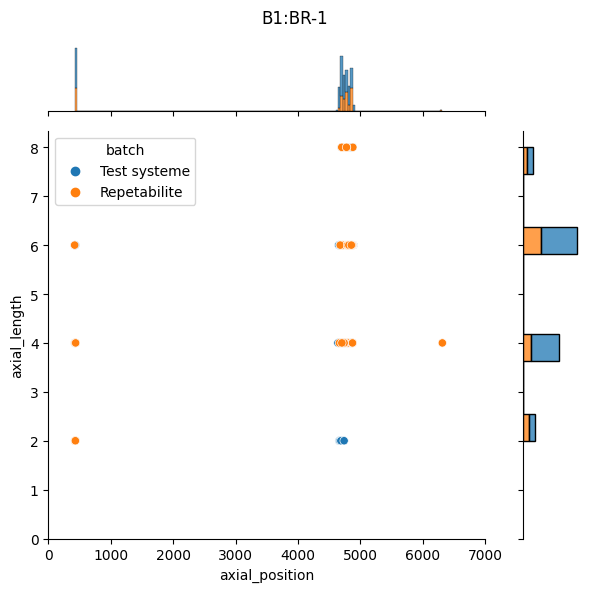

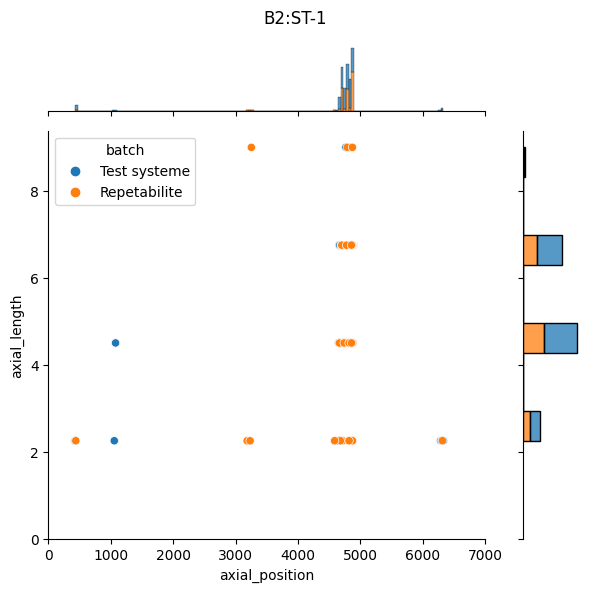

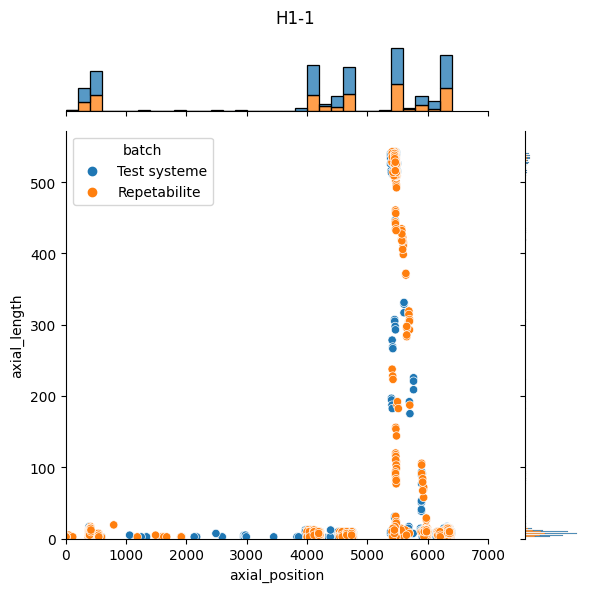

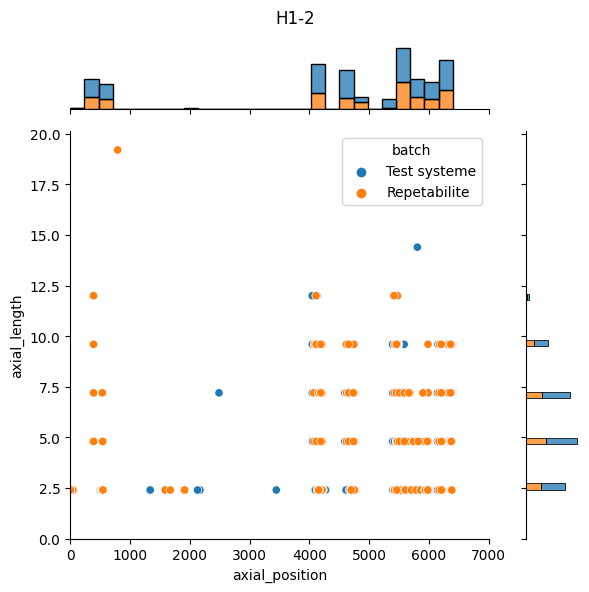

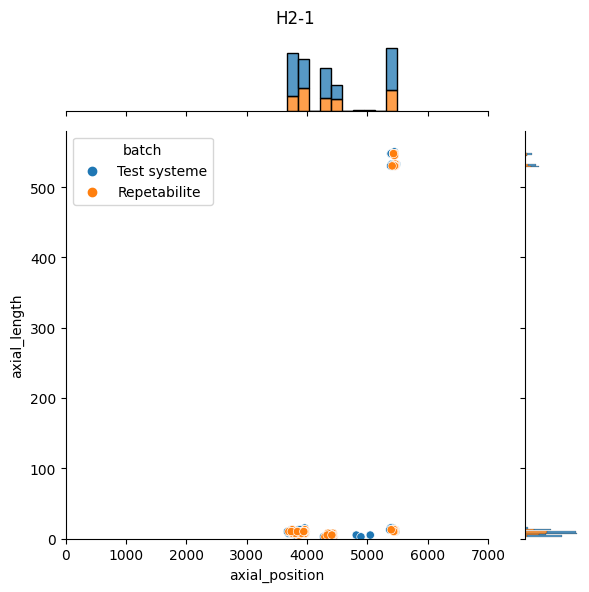

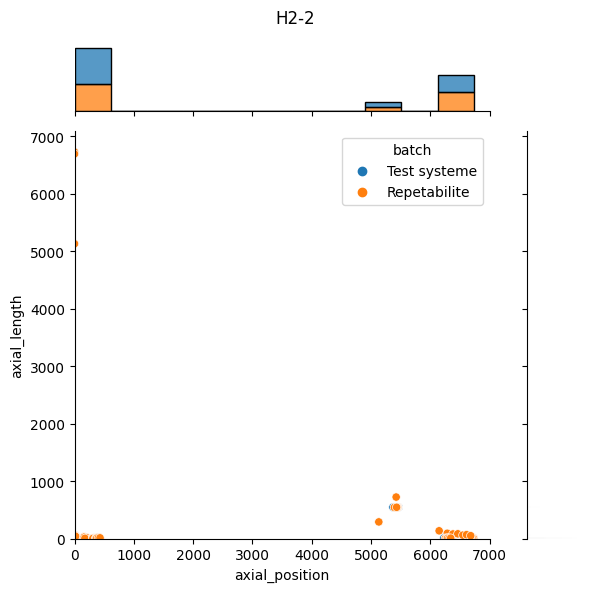

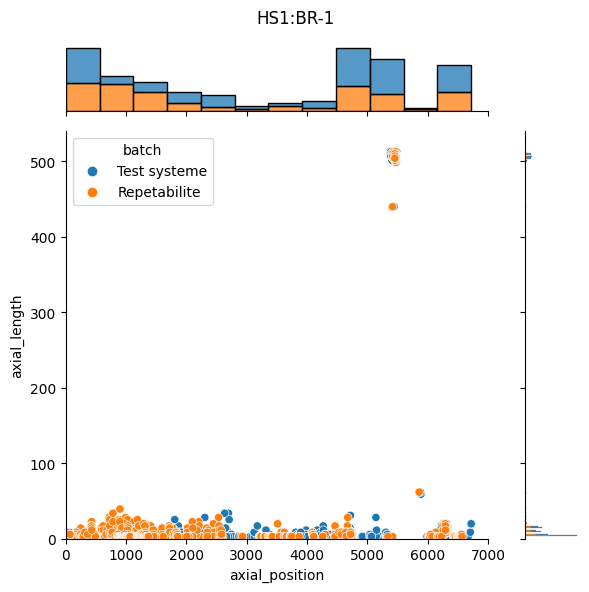

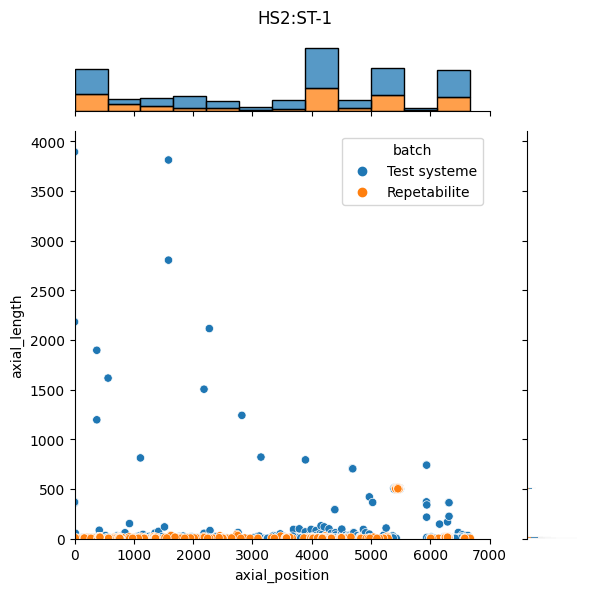

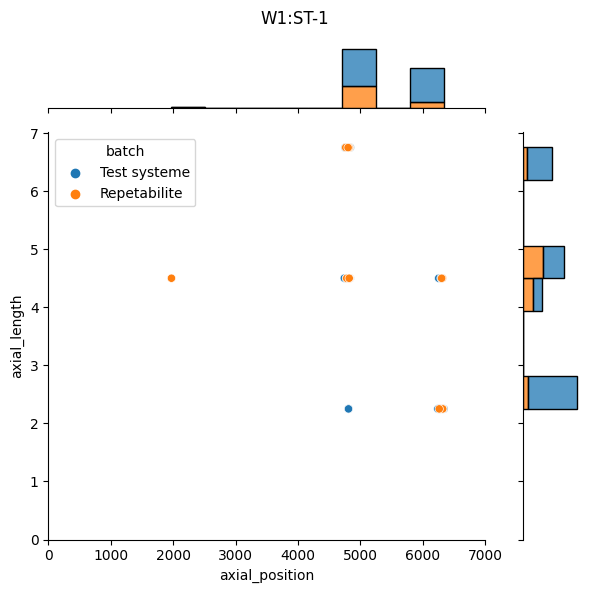

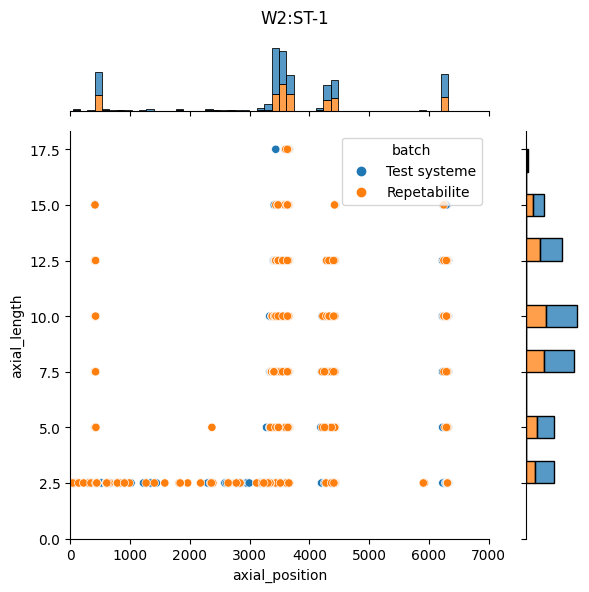

In [9]:
for channel, df in defects_1d_ut.groupby('channel'):
    # Set defaults
    df = df.reset_index()
    x='axial_position'
    y='axial_length'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        ax=g.ax_joint
    )
    # Add distributions, stacked & split by batch run
    sns.histplot(
        data=df, 
        x=x, 
        hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

Many of the results have strong amounts of ordering. I'm not sure what to make of the "axial_length" values. They appear to be equally spaced, and curiously have no spread in this dimension. My initial assumption that these values are coordinates relative to a datum is likely incorrect. Additionally, what axial length represents may be channel specific. Further consultation with the vendor may reveal what this dimension truly represents. 

The "axial_position" data does have some variation in it. The range of values is representative of looking at the full length of the inspection piece. 

From these visualizations, it is also apparent that the two data sets represent different test runs. This is most obvious when looking at the "axial_position" histograms.

### Focused look at data spread
Looking at one region, I wanted to see how much spread in the axial position for a single defect. Before I compiled the actual defect list I picked what I thought was a single target with 240 mm of spread. Based on this view I tried subtracting the smallest target axial_position value for each piece. The intention was to collapse the spread onto more repeatable positions, with less overall spread. The resulting values did not accomplish this. Through some short sighted calculations, everything was shifted over a significant amount. 

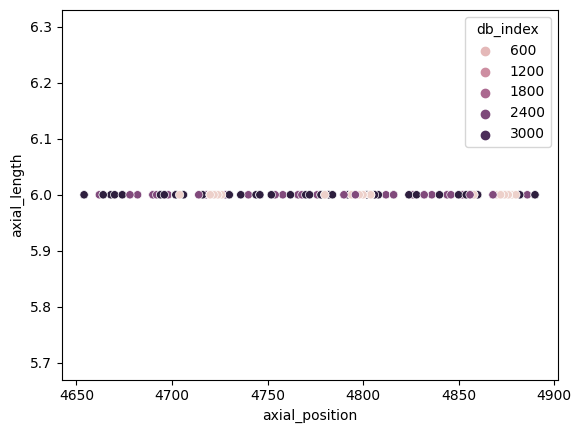

In [27]:
# Original inspection of defect spread
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000) & 
    (defects_1d_ut['axial_length'] == 6.0),
    ['axial_length', 'axial_position']
    ]
sns.scatterplot(
    data=displacements, 
    x='axial_position', 
    y='axial_length', 
    hue=displacements.index.get_level_values('db_index'),
    legend=True
);

After compiling the target data, between 4000 and 5000 mm there are actually 4 real targets. To separate these distinct values, a new visualization approach is needed. I want to look at the results of each piece individually. There is too much spread between the three groups of piece index, so I focused on the highest value group (index above 3000). A color pallet was used which cycles the colors so adjacent values from different pieces are distinctly different. 

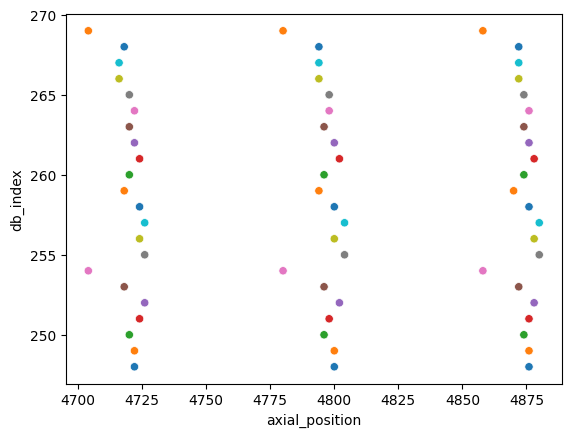

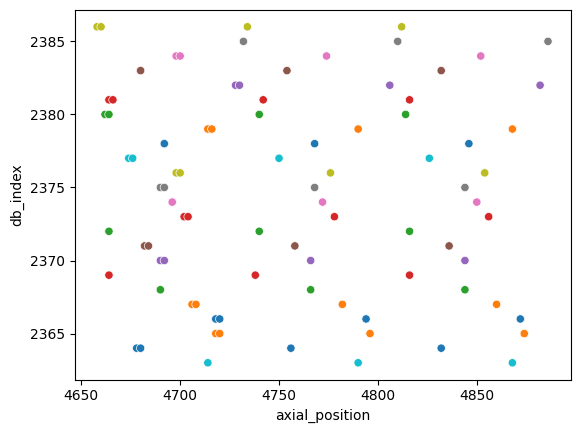

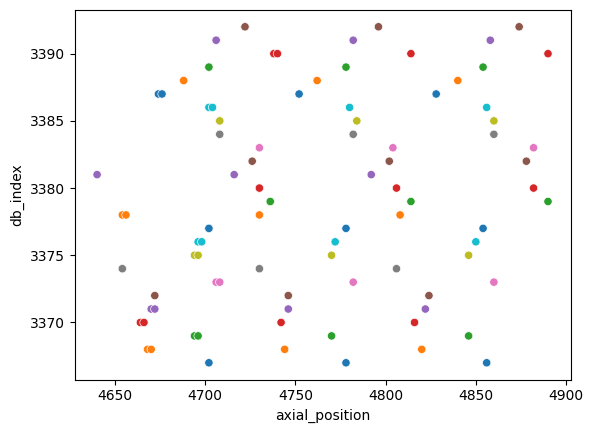

In [34]:
# Revised spread inspection, three index ranges
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000) & 
    #(defects_1d_ut['axial_length'] == 6.0) &
    (defects_1d_ut.index.get_level_values('db_index')<2000),
    ['axial_length', 'axial_position']
    ]
sns.scatterplot(
    data=displacements, 
    x='axial_position', 
    y=displacements.index.get_level_values('db_index'), #'axial_length', 
    hue=displacements.index.get_level_values('db_index').astype(str),
    palette='tab10',
    legend=False,
)
plt.show();
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000) & 
    #(defects_1d_ut['axial_length'] == 6.0) &
    (defects_1d_ut.index.get_level_values('db_index')>2000) &
    (defects_1d_ut.index.get_level_values('db_index')<3000),
    ['axial_length', 'axial_position']
    ]
sns.scatterplot(
    data=displacements, 
    x='axial_position', 
    y=displacements.index.get_level_values('db_index'), #'axial_length', 
    hue=displacements.index.get_level_values('db_index').astype(str),
    palette='tab10',
    legend=False,
)
plt.show();
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000) & 
    #(defects_1d_ut['axial_length'] == 6.0) &
    (defects_1d_ut.index.get_level_values('db_index')>3000),
    ['axial_length', 'axial_position']
    ]
sns.scatterplot(
    data=displacements, 
    x='axial_position', 
    y=displacements.index.get_level_values('db_index'), #'axial_length', 
    hue=displacements.index.get_level_values('db_index').astype(str),
    palette='tab10',
    legend=False,
)
plt.show();

For each piece in this grouping, there appears to be consistently be three distinct values. The amount of shifting is still significant for the higher indexed values, likely from poor zero positioning of the rail entering the system. In the third figure, the second purple point from 3381 leads the first point from 3380. If I was to evaluate the presence of a target strictly by position, I would get incorrect classification for one of these two rails, even though both had three values present. 

To make these values line up, they will need to be shifted over. I'll use the differences for this channel as the baseline. The shifting I'll perform is a linear transform. This method does not account for possible slippage, shifting the axial position.

# Shifting Axial Positions
To improve the axial positions data for UT, and likely for the EC data, I will determine the amount needed to shift the smallest value greater than 4500 on channel B1:BR-1 to a position of 4693.4 mm. This is the position of the smallest target on this channel. This difference can then be applied to every axial position (per piece). The hope is to normalize the data to improve classification. 

In [47]:
displacements = defects_1d_ut.loc[
    (defects_1d_ut['channel'] == 'B1:BR-1') &
    (defects_1d_ut['axial_position'] > 4000) & 
    (defects_1d_ut['axial_position'] < 5000),
    'axial_position'
    ]
displacement_shift_by_id = 4693.412-displacements.groupby(level='db_index').min()
displacement_shift_by_id

db_index
248    -28.588
249    -28.588
250    -26.588
251    -30.588
252    -32.588
         ...  
3388     5.412
3389    -8.588
3390   -44.588
3391   -12.588
3392   -28.588
Name: axial_position, Length: 72, dtype: float64

In [48]:
displacement_shift_by_id.loc[2366]

-24.587999999999738

In [44]:
defects_1d_ut

axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                5.600   
                                              1                2.800   
                                              2                2.800   
                                              3                7.500   
                                              4                9.600   
...                                                              ...   
                        Repetabilite 2373     557              2.800   
                                              558              2.800   
                                              559              2.800   
                                              560              5.600   
                                              561              2.801   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   
...                                                                ...   
                        Repetabilite 2373     557             6543.600   
                                              558             6549.200   
                                              559             6554.800   
                                              560             6560.400   
                                              561             6568.799   

                                                         channel  
order                   batch        db_index sequence            
RAIL 136 PROVE UP FINAL Test systeme 2366     0         HS1:BR-1  
                                              1         HS1:BR-1  
                                              2         HS2:ST-1  
                                              3             H2-2  
                                              4             H1-1  
...                                                          ...  
                        Repetabilite 2373     557       HS1:BR-1  
                                              558       HS1:BR-1  
                                              559       HS1:BR-1  
                                              560       HS1:BR-1  
                                              561       HS1:BR-1  

[16245 rows x 3 columns]

In [53]:
defects_1d_ut['shifted_position'] = (
    defects_1d_ut.swaplevel('db_index', 'order')['axial_position'] +\
        displacement_shift_by_id
).swaplevel('db_index', 'order')
defects_1d_ut

axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     0                5.600   
                                              1                2.800   
                                              2                2.800   
                                              3                7.500   
                                              4                9.600   
...                                                              ...   
                        Repetabilite 2373     557              2.800   
                                              558              2.800   
                                              559              2.800   
                                              560              5.600   
                                              561              2.801   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0                 11.200   
                                              1                238.000   
                                              2                282.800   
                                              3                367.500   
                                              4                374.399   
...                                                                ...   
                        Repetabilite 2373     557             6543.600   
                                              558             6549.200   
                                              559             6554.800   
                                              560             6560.400   
                                              561             6568.799   

                                                         channel  \
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     0         HS1:BR-1   
                                              1         HS1:BR-1   
                                              2         HS2:ST-1   
                                              3             H2-2   
                                              4             H1-1   
...                                                          ...   
                        Repetabilite 2373     557       HS1:BR-1   
                                              558       HS1:BR-1   
                                              559       HS1:BR-1   
                                              560       HS1:BR-1   
                                              561       HS1:BR-1   

                                                        shifted_position  
order                   batch        db_index sequence                    
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  -13.388  
                                              1                  213.412  
                                              2                  258.212  
                                              3                  342.912  
                                              4                  349.811  
...                                                                  ...  
                        Repetabilite 2373     557               6535.012  
                                              558               6540.612  
                                              559               6546.212  
                                              560               6551.812  
                                              561               6560.211  

[16245 rows x 4 columns]

## Additional Exploration
Given sufficient time to code, an algorithm can be developed to optimize the amount of axial shift for each piece, and improve classification. The target locations are fixed. The defect positions can be convolved with a reasonable travel distance over this position list. Minimizing the median distance between each indication and the closest target would yield the best shifted distance. A classification could the be performed based on distance to limit one classified value per target. 

# Classifying Known UT Targets
With the piece's axial position coordinates hopefully more aligned, I want to determine which pieces did not have targets in their intended locations. Additionally knowing which targets were missed will be equally important.

The first step is to perform a quick classification of each defect, giving it a position designation, or nothing if the defect is not close to a target.

In [59]:
import numpy as np

defects_1d_ut_classified = defects_1d_ut.copy()
defects_1d_ut_classified['target_id'] = np.nan

for channel in defects_1d_ut_classified['channel'].unique():
    try:
        targets = target_locations.loc[
            channel, 
            ['axial_location', 'pre', 'post']
        ]
    except KeyError:
        print(f'Channel {channel} not found in target list')
        continue
    for idx, target in targets.iterrows():
        defects_1d_ut_classified.loc[ 
            (defects_1d_ut_classified['channel'] == channel) &
            (defects_1d_ut_classified['shifted_position'] > target['pre']) &
            (defects_1d_ut_classified['shifted_position'] < target['post'])
            ,
            'target_id'
        ] = target['axial_location']

defects_1d_ut_classified.dropna(subset='target_id')

Channel HS2:ST-1 not found in target list


axial_length  \
order                   batch        db_index sequence                 
RAIL 136 PROVE UP FINAL Test systeme 2366     149             12.500   
                                              150             12.500   
                                              152             15.000   
                                              194              5.000   
                                              196              5.000   
...                                                              ...   
                        Repetabilite 2373     409              4.801   
                                              410              7.200   
                                              412              4.799   
                                              413              4.801   
                                              415              7.200   

                                                        axial_position  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     149             3752.500   
                                              150             3857.500   
                                              152             3960.000   
                                              194             4267.500   
                                              196             4270.000   
...                                                                ...   
                        Repetabilite 2373     409             5587.199   
                                              410             5664.000   
                                              412             5743.200   
                                              413             5819.999   
                                              415             5896.800   

                                                        channel  \
order                   batch        db_index sequence            
RAIL 136 PROVE UP FINAL Test systeme 2366     149          H2-1   
                                              150          H2-1   
                                              152          H2-1   
                                              194       W2:ST-1   
                                              196       W2:ST-1   
...                                                         ...   
                        Repetabilite 2373     409          H1-2   
                                              410          H1-2   
                                              412          H1-2   
                                              413          H1-2   
                                              415          H1-2   

                                                        shifted_position  \
order                   batch        db_index sequence                     
RAIL 136 PROVE UP FINAL Test systeme 2366     149               3727.912   
                                              150               3832.912   
                                              152               3935.412   
                                              194               4242.912   
                                              196               4245.412   
...                                                                  ...   
                        Repetabilite 2373     409               5578.611   
                                              410               5655.412   
                                              412               5734.612   
                                              413               5811.411   
                                              415               5888.212   

                                                        target_id  
order                   batch        db_index sequence             
RAIL 136 PROVE UP FINAL Test systeme 2366     149           116.0  
                                              150           112.0  
                       

3.6 thousand defects have been classified, and 12.6 thousand defects have been removed from the dataset because they weren't close to a target. Visualizing the target boundaries versus the actual data set shows where the important regions are for inspection.

Channel HS2:ST-1 not found in target list


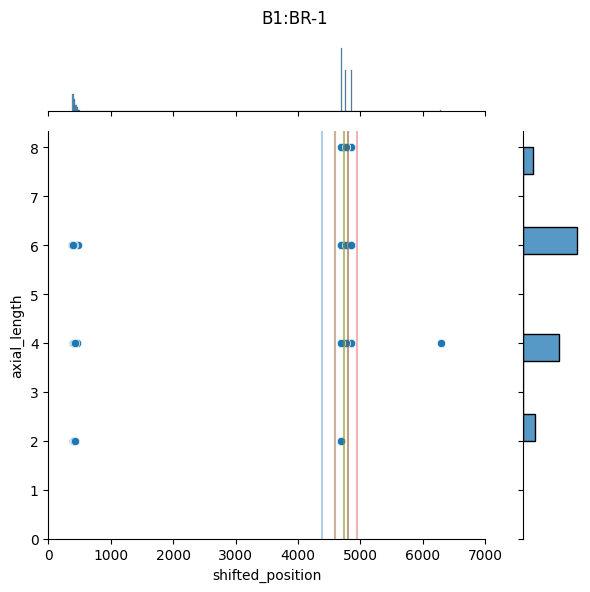

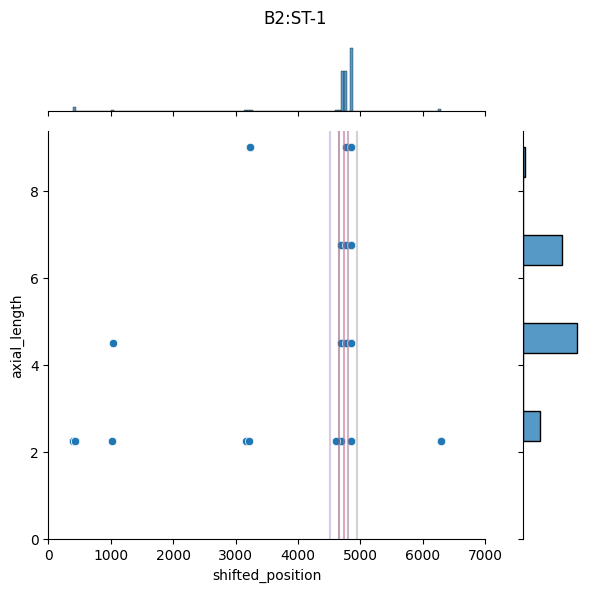

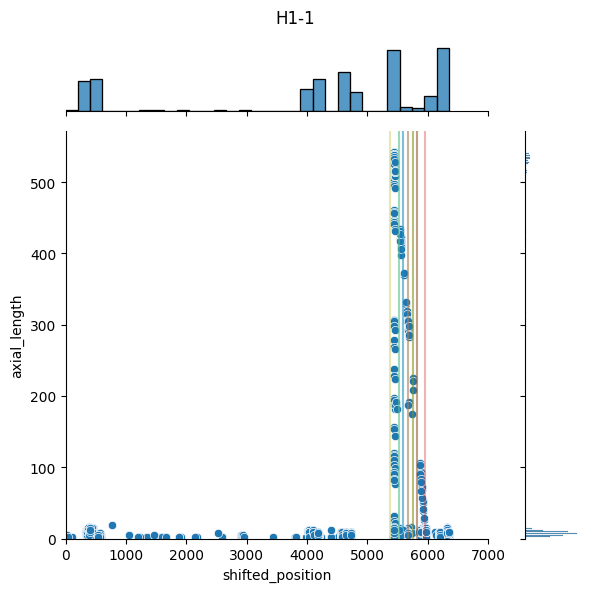

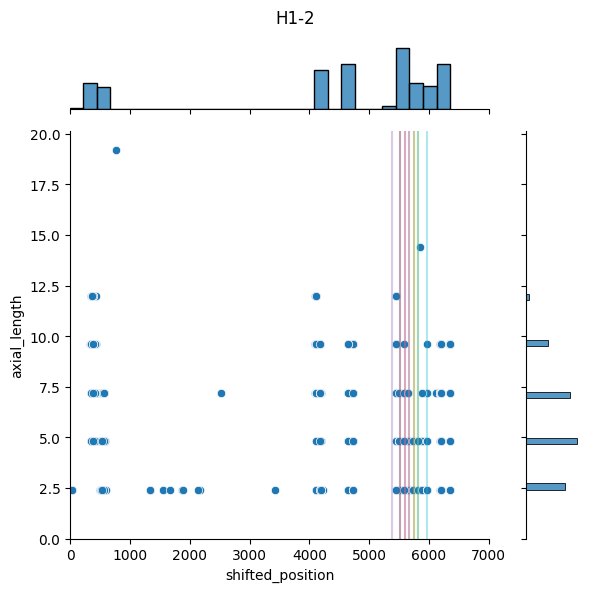

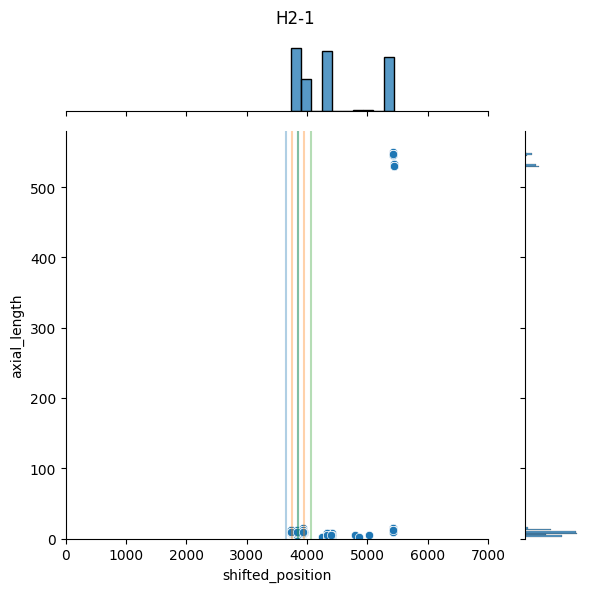

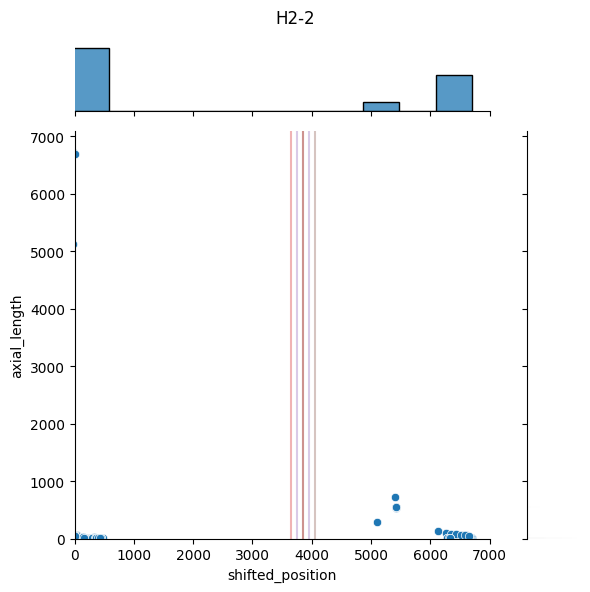

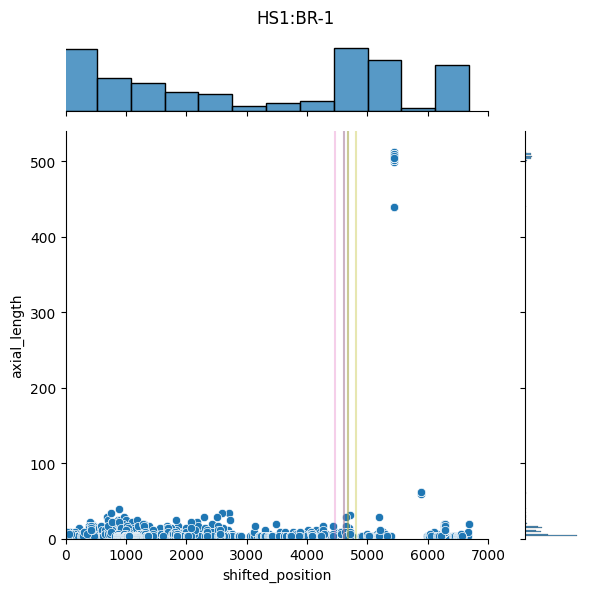

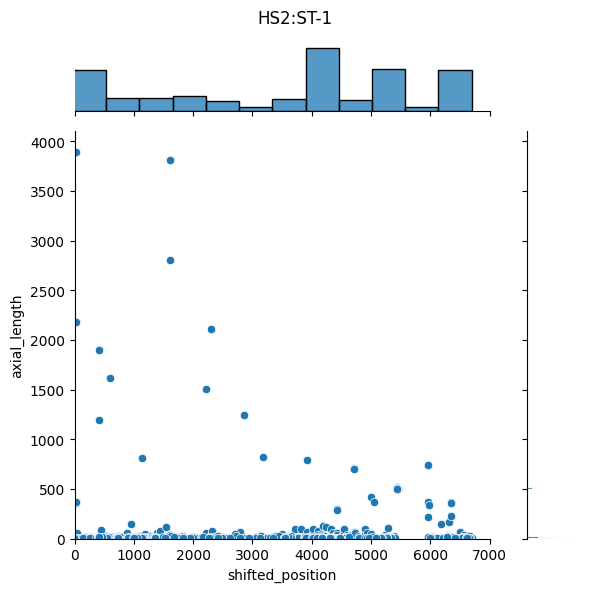

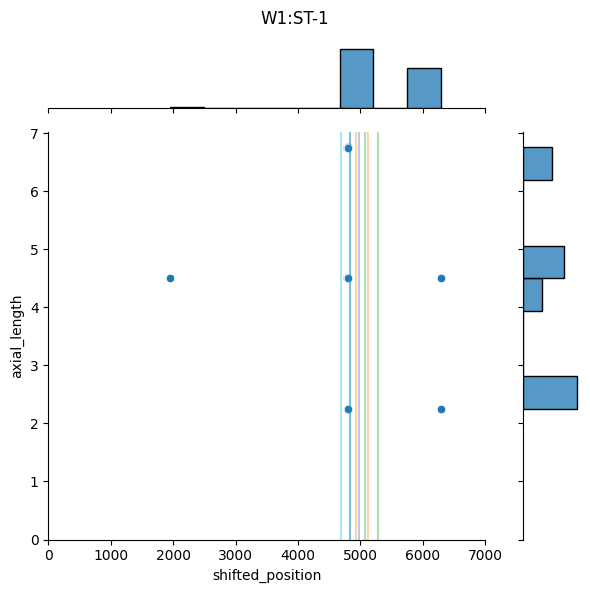

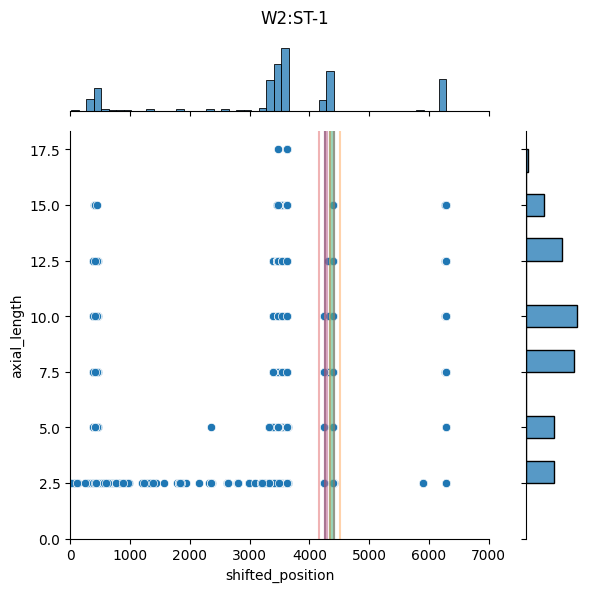

In [60]:
# color cycler from https://stackoverflow.com/questions/28430385/seaborn-cycle-through-colours-with-matplotlib-scatter
from itertools import cycle
palette = cycle(sns.color_palette())

for channel, df in defects_1d_ut.groupby('channel'):
    # Set defaults
    df = df.reset_index()
    x='shifted_position'
    y='axial_length'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        #hue='amplitude', 
        ax=g.ax_joint
    )
    try:
        targets = target_locations.loc[channel, ['pre', 'post']]
        for idx, target in targets.iterrows():
            color=next(palette)
            g.ax_joint.axvline(target['pre'], alpha=.35, color=color)
            g.ax_joint.axvline(target['post'], alpha=.35, color=color)
    except KeyError:
        print(f'Channel {channel} not found in target list')

    sns.histplot(
        data=df, 
        x=x, 
        #hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        #hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()


The next objective is to determine which targets were not found in each test run. To begin, I set both the defect list and the target list to the same indices, i.e. channel and target id. For each piece, I left join the target list to the defect list. If there is an index in the target list which is not in the defect list, it is filled with a count of zero. I use groupby to condense the the defect list with an additional dimension of the index_id to look at each piece individually. 

In [81]:
# Group defects by channel, location and piece. Count defect instances
defects_1d_ut_counts = (
    defects_1d_ut_classified
    .dropna()
    .reset_index(level='db_index') #quick move to make groupby syntax easier
    .groupby(
        ['db_index', 'channel', 'target_id']
    )
    ['axial_position'] # Get location only, results in a series
    .count()
    .rename('count')
    .to_frame()
)
defects_1d_ut_counts.head()

count
db_index channel target_id       
248      B1:BR-1 73.0           1
                 76.0           1
                 79.0           1
         B2:ST-1 73.0           2
                 76.0           1

In [79]:
# Group targets by channel and location
ut_targets = (
    target_locations
    .loc[
        target_locations['inspection_equipment'] == 'UT'
        , 'axial_location'
    ]
    .rename('target_id')
    .droplevel(-1)
    .reset_index()
)
ut_targets['count'] = 0
ut_targets = ut_targets.set_index(['channel', 'target_id'])
ut_targets.head()

count
channel target_id       
B1:BR-1 87.0           0
        79.0           0
        76.0           0
        73.0           0
B2:ST-1 82.0           0

In [76]:
# Iterate over all of the pieces
# Define the piece list
db_indexes = (
    defects_1d_ut_counts
    .index
    .get_level_values('db_index')
    .unique()
)

# Iterate and combine. Using update to overlay defect list over targets
rails = []
for rail in db_indexes:
    df = ut_targets.copy()
    df.update(defects_1d_ut_counts.loc[rail])
    rails.append(df)

ut_counts = pd.concat(rails, keys=db_indexes)
ut_counts.head(20)

count
db_index channel target_id       
248      B1:BR-1 87.0         0.0
                 79.0         1.0
                 76.0         1.0
                 73.0         1.0
         B2:ST-1 82.0         0.0
                 79.0         1.0
                 76.0         1.0
                 73.0         2.0
         H1-1    48.0        15.0
                 45.0         0.0
                 42.0         5.0
                 39.0         0.0
                 36.0         0.0
                 33.0         0.0
         H1-2    48.0         5.0
                 45.0         2.0
                 42.0         2.0
                 39.0         1.0
                 36.0         1.0
                 33.0         2.0

With all of the values combined, I can find the zero counts. These are the combinations which were not found for each channel, location and piece combination. 

In [77]:
ut_misses = ut_counts[ut_counts['count'] == 0]

,db_index,channel,target_id,count
0,248,B1:BR-1,87.0,0.0
1,248,B2:ST-1,82.0,0.0
2,248,H1-1,45.0,0.0
3,248,H1-1,39.0,0.0
4,248,H1-1,36.0,0.0
...,...,...,...,...
1128,3392,HS1:ST-1,102.0,0.0
1129,3392,HS1:ST-1,99.0,0.0
1130,3392,W1:ST-1,72.0,0.0
1131,3392,W1:ST-1,66.0,0.0


For 72 pieces, and 45 UT targets there were 1133 misses. That is 35% of possible combinations were not found. I will look at how much each target was missed to see if there are any patterns. I suspect that some of the targets may not be in the per-print locations.

In [97]:
ut_miss_counts = ut_misses.groupby(['channel', 'target_id'])['count'].count()
ut_miss_counts

channel   target_id
B1:BR-1   87.0         72
B2:ST-1   82.0         71
H1-1      33.0         62
          36.0         71
          39.0         67
          42.0         66
          45.0         67
H2-1      108.0         3
          112.0         3
          116.0         3
H2-2      108.0        72
          112.0        72
          116.0        72
HS1:ST-1  99.0         72
          102.0        72
          105.0        72
W1:ST-1   60.0         72
          66.0         72
          72.0         72
Name: count, dtype: int64

There are 10 targets which were not identified on any of the test runs. There were another 6 where they were missed at least 85% of the time. I suspect that this second grouping of targets needs some improvements in detection parameters on the equipment. One target was missed by all test runs but one. This likely is a false positive, so a 95% confidence was added to the exclusion list called "always miss".

In [99]:
ut_always_miss = (
    ut_miss_counts
    [ut_miss_counts > 0.95 * len(db_indexes)]
    .index
    .unique()
    #.to_frame()
)
ut_always_miss

MultiIndex([( 'B1:BR-1',  87.0),
            ( 'B2:ST-1',  82.0),
            (    'H1-1',  36.0),
            (    'H2-2', 108.0),
            (    'H2-2', 112.0),
            (    'H2-2', 116.0),
            ('HS1:ST-1',  99.0),
            ('HS1:ST-1', 102.0),
            ('HS1:ST-1', 105.0),
            ( 'W1:ST-1',  60.0),
            ( 'W1:ST-1',  66.0),
            ( 'W1:ST-1',  72.0)],
           names=['channel', 'target_id'])

Reprocessing the miss counts excluding the always misses allows me to see how often the remaining targets are missed. If it isn't on the list, it was always found.

In [100]:
ut_miss_counts = ut_miss_counts[ut_miss_counts < 0.95 * len(db_indexes)]
miss_rate = ut_miss_counts/len(db_indexes)
miss_rate

channel  target_id
H1-1     33.0         0.861111
         39.0         0.930556
         42.0         0.916667
         45.0         0.930556
H2-1     108.0        0.041667
         112.0        0.041667
         116.0        0.041667
Name: count, dtype: float64

The final processed list identifies misses by each piece, channel, location. This excludes the "always miss" targets. This final data is what would be uploaded to the production database for certification review for each pass. 

In [159]:
(
    ut_counts
    .reset_index('db_index')
    .loc[
        ~ut_counts.reset_index('db_index').index.isin(ut_always_miss) &
        (ut_counts['count'] == 0).to_numpy() &
        (ut_counts.index.get_level_values('channel') != ':OB'),
        'db_index'
    ]
    .reset_index()
    .set_index('db_index')
)

,channel,target_id
db_index,,
248,B2:ST-1,82.0
248,H1-1,45.0
248,H1-1,33.0
248,H2-1,116.0
249,B2:ST-1,82.0
...,...,...
3392,B2:ST-1,82.0
3392,H1-1,45.0
3392,H1-1,39.0


# EDA Eddy Current
The analysis path for Eddy Current is very similar to what was done for Ultrasonic defects. Once the defect list is created with locations, they are identical. I didn't realize how similar they were until much later in the process. For the production script, I will combine these sets together as a single DataFrame, with one additional "type" value to keep channel associations.


In [101]:
# Recap of data structure
print(defects_2d_ec_raw.info())
defects_2d_ec_raw.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24438 entries, ('RAIL 136 PROVE UP FINAL', 'Test systeme', 2366, 0) to ('RAIL 136 PROVE UP FINAL', 'Repetabilite', 2373, 335)
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   alarm_id      24438 non-null  int64  
 1   amplitude     24438 non-null  float64
 2   channel_id    24438 non-null  int64  
 3   data_type     24438 non-null  object 
 4   group_id      24438 non-null  int64  
 5   channel_name  24438 non-null  object 
 6   top           24438 non-null  float64
 7   left          24438 non-null  float64
 8   bottom        24438 non-null  float64
 9   right         24438 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.0+ MB
None


alarm_id  amplitude  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1      -2.36   
                                              1                1       4.14   
                                              2                1       2.78   
                                              3                1      -2.01   
                                              4                1      -5.00   

                                                        channel_id data_type  \
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     0                  1       All   
                                              1                  1       All   
                                              2                  1       All   
                                              3                  1       All   
                                              4                  1       All   

                                                        group_id channel_name  \
order                   batch        db_index sequence                          
RAIL 136 PROVE UP FINAL Test systeme 2366     0                1     CHRS1:LT   
                                              1                1     CHRS1:LT   
                                              2                1     CHRS1:LT   
                                              3                1     CHRS1:LT   
                                              4                1     CHRS1:LT   

                                                         top   left  bottom  \
order                   batch        db_index sequence                        
RAIL 136 PROVE UP FINAL Test systeme 2366     0         64.0  437.0    60.0   
                                              1         68.0  441.0    64.0   
                                              2         59.0  442.0    55.0   
                                              3         64.0  449.0    60.0   
                                              4         68.0  539.0    21.0   

                                                        right  
order                   batch        db_index sequence         
RAIL 136 PROVE UP FINAL Test systeme 2366     0         440.0  
                                              1         446.0  
                                              2         446.0  
                                              3         450.0  
                                              4         550.0

## Exploring Variation in EC Data
Just like with the ultrasonic data, I want to confirm that the test data does have variation, and isn't the exact same data set repeated multiple times. Looking at the results, I feel that because there are a range of defects found, it isn't the same data repeated. 

In [103]:
# Confirming some variation in the data, it isn't duplicated
defects_2d_ec_raw.alarm_id.groupby(level=[1, 2]).count()

batch         db_index
Repetabilite  248         313
              249         328
              250         329
              251         318
              252         321
                         ... 
Test systeme  3388        364
              3389        367
              3390        363
              3391        344
              3392        346
Name: alarm_id, Length: 72, dtype: int64

Descriptive statistics also help determine which values have no change, and can be excluded. 

In [104]:
defects_2d_ec_raw.describe()

,alarm_id,amplitude,channel_id,group_id,top,left,bottom,right
count,24438.0,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000,24438.000000
mean,1.0,0.125636,15.578771,15.578771,65.483305,3594.158073,55.503601,3607.012603
std,0.0,3.247851,7.691689,7.691689,44.699396,2133.182596,46.440112,2136.505068
min,1.0,-5.000000,1.000000,1.000000,4.000000,398.000000,0.000000,399.000000
25%,1.0,-2.630000,11.000000,11.000000,12.000000,1588.000000,0.000000,1613.250000
50%,1.0,2.040000,19.000000,19.000000,68.000000,3749.000000,55.000000,3758.000000
75%,1.0,2.830000,23.000000,23.000000,111.000000,5726.000000,107.000000,5739.000000
max,1.0,5.000000,24.000000,24.000000,124.000000,6324.000000,120.000000,6330.000000


Alarm ID is the only variable that does not change across the whole data set. I will check to see if, like ultrasonic, there is a correlation of channel ID and group ID. The values which change would be the dimensional components and the amplitude.

In [105]:
defects_2d_ec_raw[[
    #'alarm_id', 
    #'amplitude', 
    'channel_id', 
    'data_type', 
    'group_id',
    'channel_name', 
    #'top', 
    #'left', 
    #'bottom', 
    #'right'
    ]].drop_duplicates().sort_values('channel_name')

channel_id data_type  \
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     248               23       All   
                                              337               24       All   
                                              104               15       All   
                                              148               16       All   
                                              32                 3       All   
                                              57                 4       All   
                                              0                  1       All   
                                              20                 2       All   
                                              209               21       All   
                                              99                13       All   
                                              153               19       All   
                                              205               20       All   
                                              71                11       All   
                                              98                12       All   
                                              69                 7       All   
                                              67                 5       All   

                                                        group_id channel_name  
order                   batch        db_index sequence                         
RAIL 136 PROVE UP FINAL Test systeme 2366     248             23       BB1:LT  
                                              337             24       BB1:OB  
                                              104             15       BS1:LT  
                                              148             16       BS1:OB  
                                              32               3     CHRB1:LT  
                                              57               4     CHRB1:OB  
                                              0                1     CHRS1:LT  
                                              20               2     CHRS1:OB  
                                              209             21      FEB1:LT  
                                              99              13      FES1:LT  
                                              153             19      IFB1:LT  
                                              205             20      IFB1:OB  
                                              71              11      IFS1:LT  
                                              98              12      IFS1:OB  
                                              69               7      SHB1:LT  
                                              67               5      SHS1:LT

In [106]:
len(defects_2d_ec_raw['channel_name'].unique())

16

There are 16 unique combinations regarding sensors. The channel_name/channel_id and group_id is a unique combination, and can be represented by just the channel name. This leaves the dimensional data, amplitude and channel as the primary characteristics to be looked at. 

## Reformatting 2D coordinates.
As it was explored already, the coordinates from the database represent a bounding box of increased signal response. I believe that changing this bounding box's representation from a box to a point with limits is more intuitive, even if both solutions use 4 factors to describe the same dimensional area. The four refactored values are the center (x-value) and middle (y-value) plus the "error" on the two dimensions. 


In [107]:
defects_2d_ec = defects_2d_ec_raw[[
    #'alarm_id', 
    'amplitude', 
    #'channel_id', 
    #'data_type', 
    #'group_id',
    'channel_name', 
    'top', 
    'left', 
    'bottom', 
    'right'
    ]].copy()

defects_2d_ec['middle'] = (defects_2d_ec_raw['top'] + defects_2d_ec_raw['bottom'])/2
defects_2d_ec['center'] = (defects_2d_ec_raw['right'] + defects_2d_ec_raw['left'])/2

defects_2d_ec['yerr'] = (defects_2d_ec_raw['top'] - defects_2d_ec_raw['bottom'])/2
defects_2d_ec['xerr'] = (defects_2d_ec_raw['right'] - defects_2d_ec_raw['left'])/2

With revised coordinates, I can plot (x, y) coordinates for each defect (center, middle). Similar to ultrasonic data, the target is supposed to be read by only one channel. I have to maintain this association throughout the rest of the analysis. 

Iterating over each channel, and displaying the coordinates should provide a good idea of how the data relates to each other. At this point, I'm also separating by the batch, to verify that each batch contains different data. 

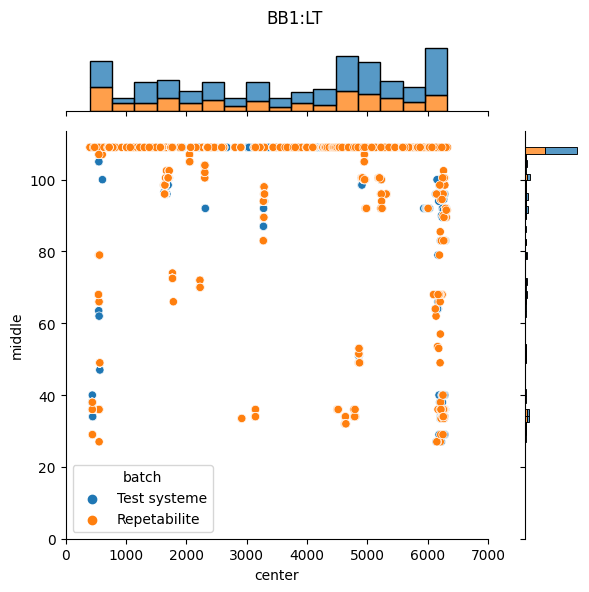

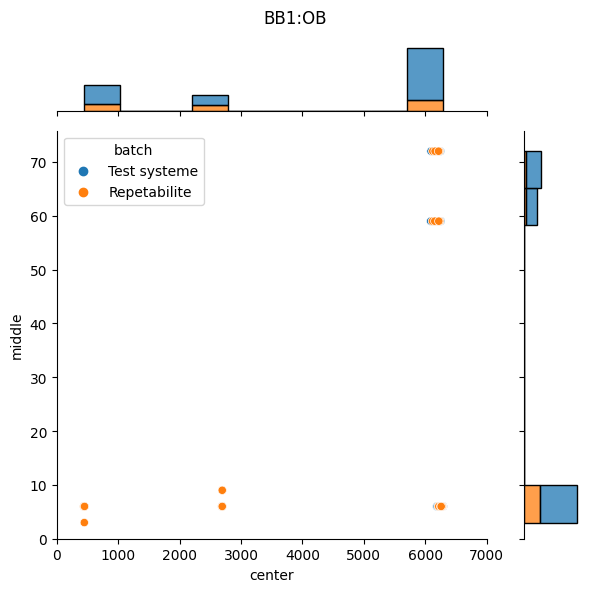

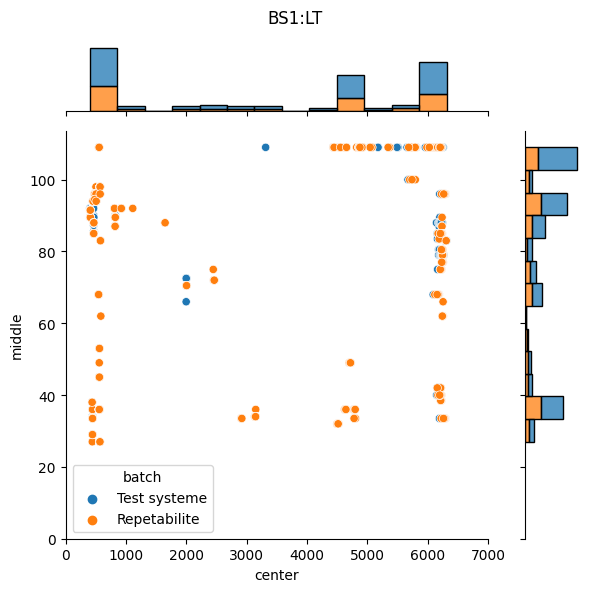

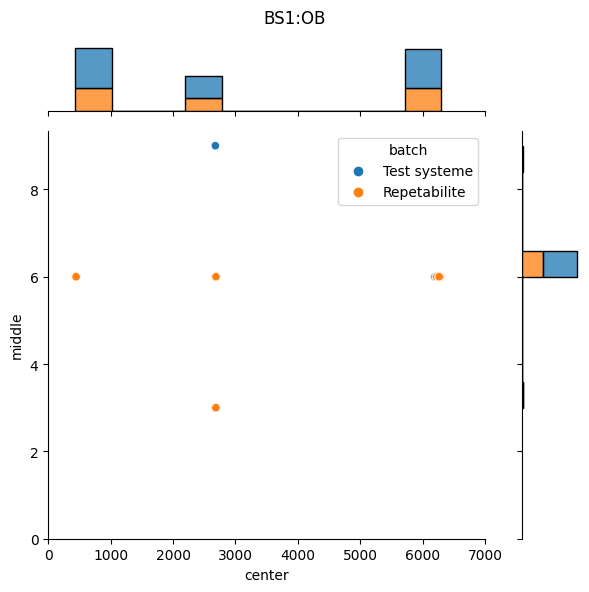

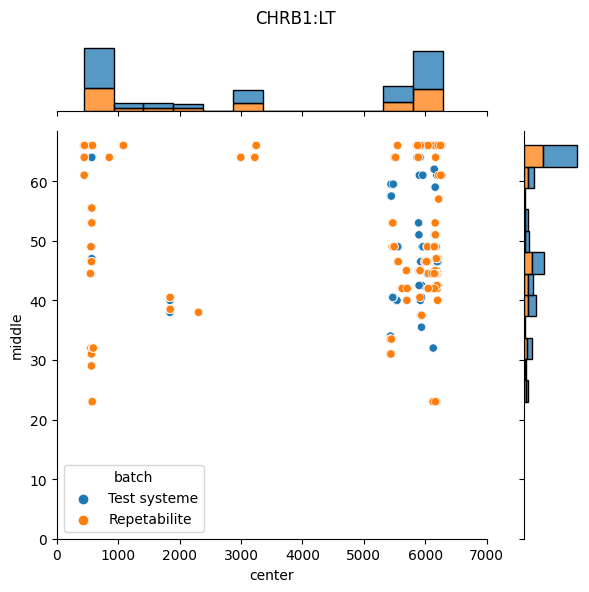

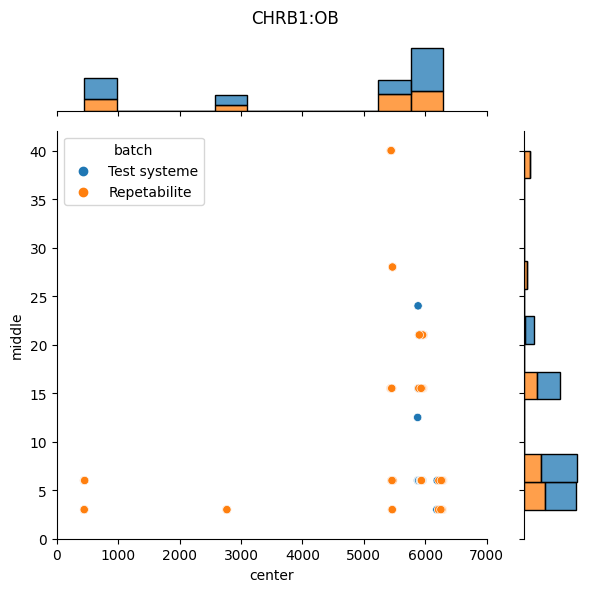

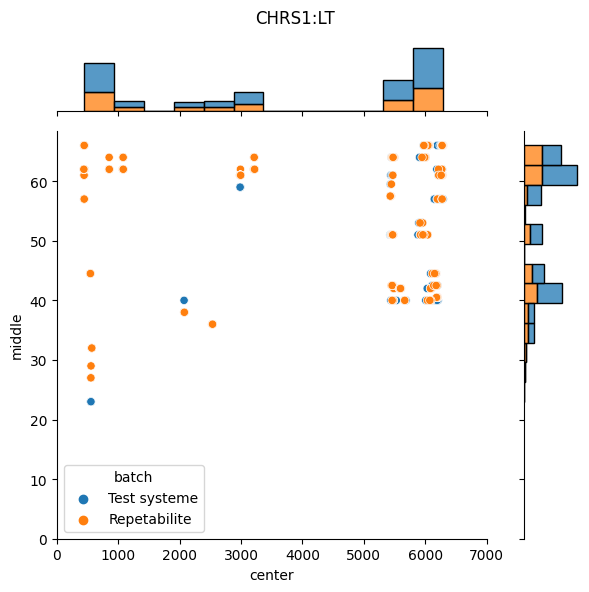

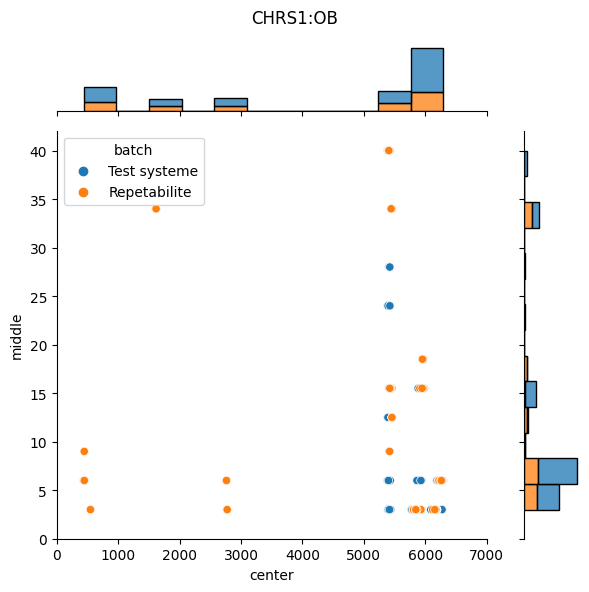

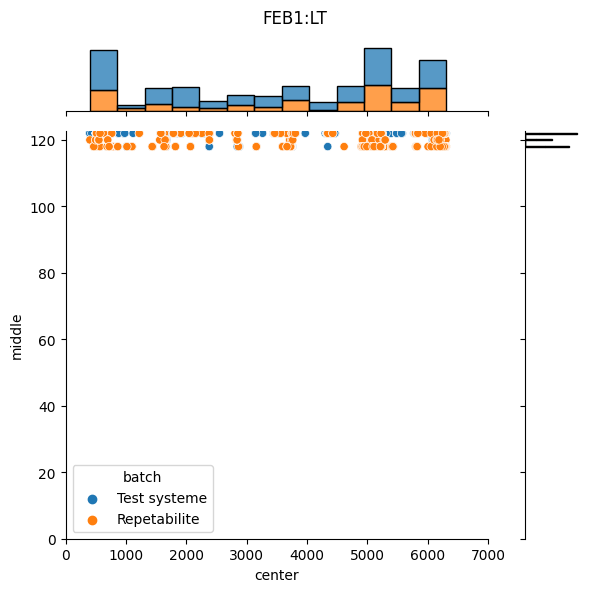

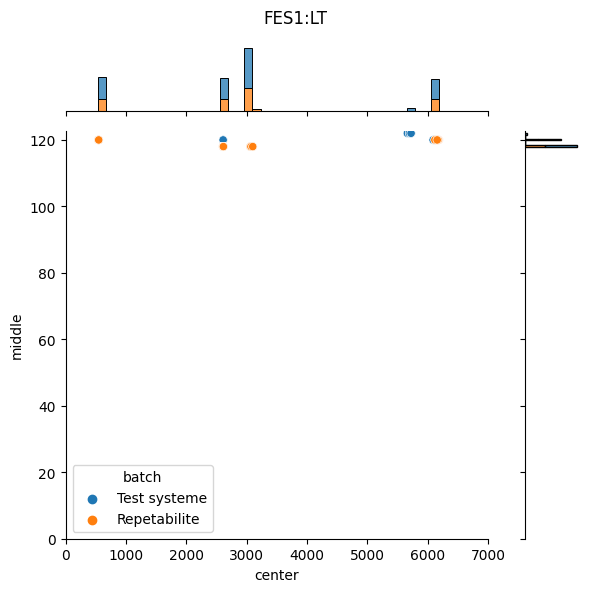

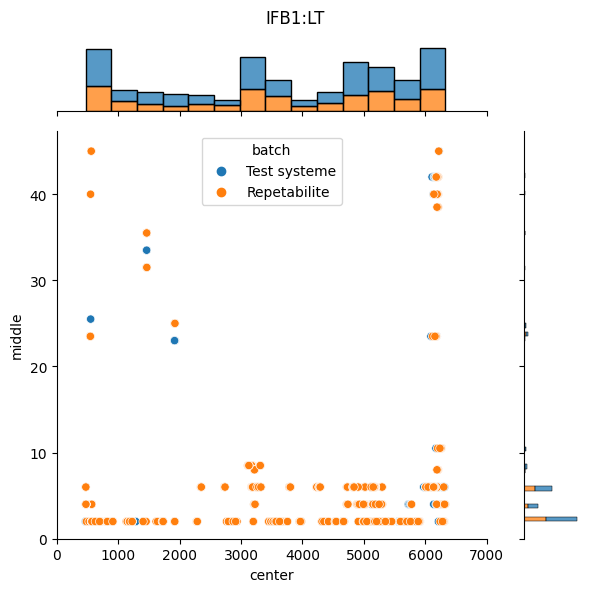

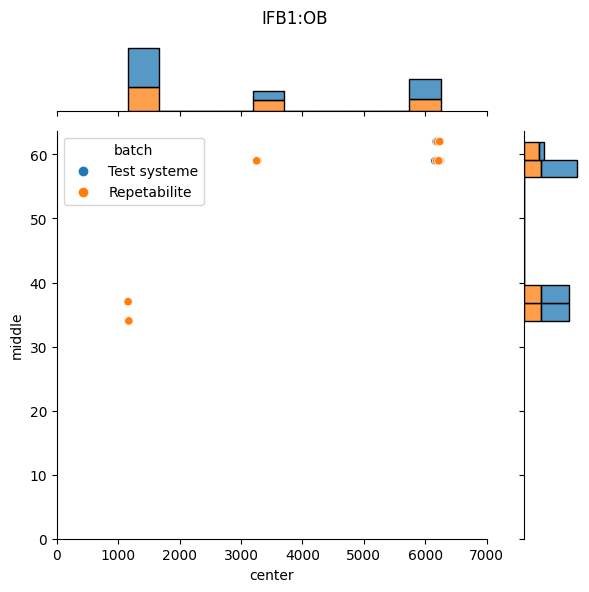

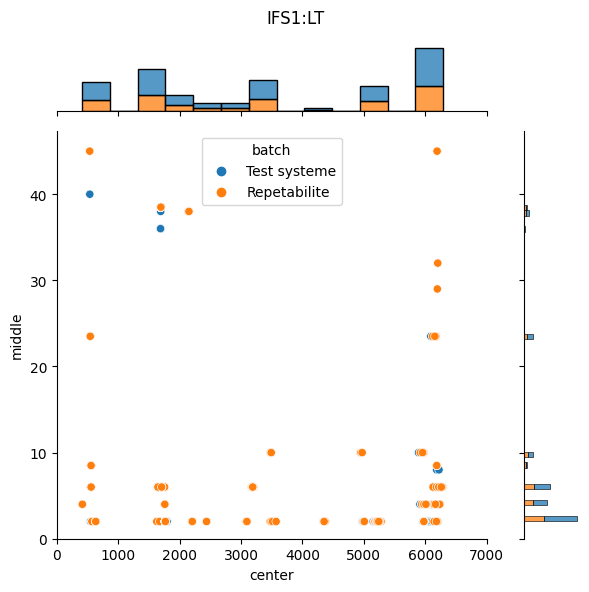

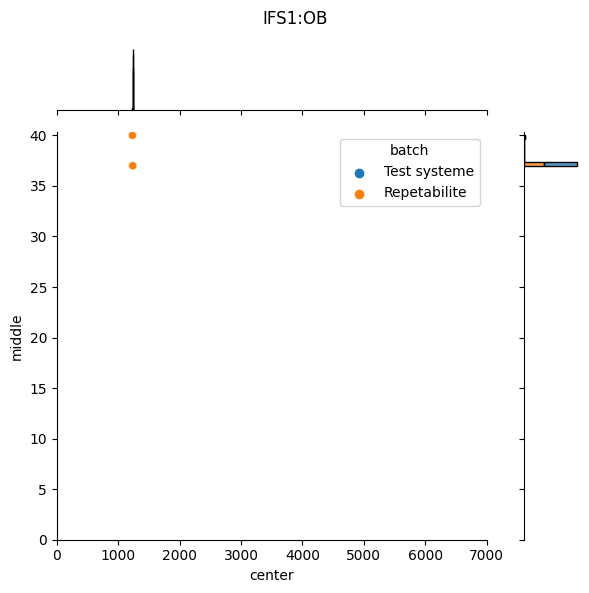

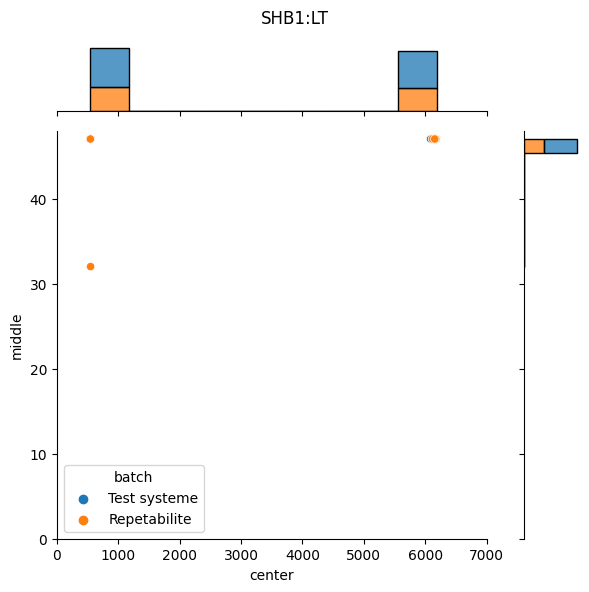

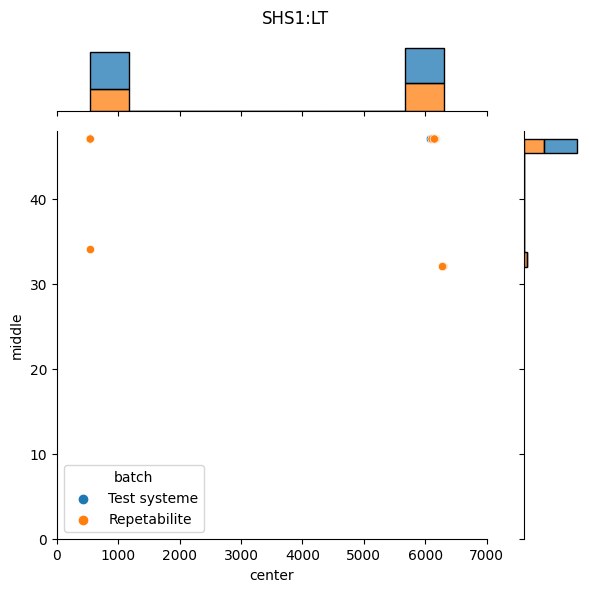

In [108]:
for channel, df in defects_2d_ec.groupby('channel_name'):
    # Set defaults
    df = df.reset_index()
    x='center'
    y='middle'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue=hue, 
        ax=g.ax_joint
    )
    # Add distributions, stacked & split by batch run
    sns.histplot(
        data=df, 
        x=x, 
        hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

Because this data is designated as 2D by the supplier, I trust that the values truly do represent a coordinate position. I was able to confirm this by spot checking some "middle" coordinates. 

Channels BB1:LT and BS1:LT have many counts at the extreme. From the dimension given, these are edge artifacts, and don't represent a true defect. I wasn't able to find any other channels with similar "saturation" at a position. 

From these visualizations, it is also apparent that the two data sets represent different test runs. 

### EC data spread
The amount of spread present in the data for a given target is complicated by the fact that Eddy Current defects are primarily grooved-in slots. This is why they are characterized with shape. Ultrasonic data is typically single points, which should make it easier to line up defects to the same coordinates. 

The easiest method to align the coordinates for EC is to use the shifting data from the evaluation in UT. 

# Shifting Axial Positions
The shift determination was already performed using UT data. THe  difference to a target location can also be applied to the center value in EC data as this falls on the same axial position axis form UT. The hope is to normalize the data to improve classification. 

In [109]:
defects_2d_ec['shifted_position'] = (
    defects_2d_ec.swaplevel('db_index', 'order')['center'] +\
        displacement_shift_by_id
).swaplevel('db_index', 'order')
defects_2d_ec

amplitude  \
order                   batch        db_index sequence              
RAIL 136 PROVE UP FINAL Test systeme 2366     0             -2.36   
                                              1              4.14   
                                              2              2.78   
                                              3             -2.01   
                                              4             -5.00   
...                                                           ...   
                        Repetabilite 2373     331            2.29   
                                              332           -2.43   
                                              333            2.30   
                                              334            4.57   
                                              335           -4.83   

                                                       channel_name   top  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0            CHRS1:LT  64.0   
                                              1            CHRS1:LT  68.0   
                                              2            CHRS1:LT  59.0   
                                              3            CHRS1:LT  64.0   
                                              4            CHRS1:LT  68.0   
...                                                             ...   ...   
                        Repetabilite 2373     331            BB1:OB  75.0   
                                              332            BB1:OB  75.0   
                                              333            BB1:OB  62.0   
                                              334            BB1:OB  12.0   
                                              335            BB1:OB  12.0   

                                                          left  bottom  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0          437.0    60.0   
                                              1          441.0    64.0   
                                              2          442.0    55.0   
                                              3          449.0    60.0   
                                              4          539.0    21.0   
...                                                        ...     ...   
                        Repetabilite 2373     331       6156.0    69.0   
                                              332       6210.0    69.0   
                                              333       6215.0    56.0   
                                              334       6250.0     0.0   
                                              335       6257.0     0.0   

                                                         right  middle  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0          440.0    62.0   
                                              1          446.0    66.0   
                                              2          446.0    57.0   
                                              3          450.0    62.0   
                                              4          550.0    44.5   
...                                                        ...     ...   
                        Repetabilite 2373     331       6165.0    72.0   
                                              332       6224.0    72.0   
                                              333       6227.0    59.0   
                                              334       6256.0     6.0   
                                              335       6263.0     6.0   

                                                        center  yerr  xerr  \
order                   batch        db_index sequence                       
RAIL 136 PROVE UP FINAL Test systeme 2366     0          438.5   2.0   1.5

## Cleaning Edge Effects
As noted previously Channels BB1:LT and BS1:LT experience some edge effects. I will remove these values to improve the integrity of the data in these channels. 

In [119]:
defects_2d_ec = (
    defects_2d_ec.loc[
        ~ (( # Find and negate the high level values
            (defects_2d_ec['channel_name'] == 'BB1:LT') & 
            (defects_2d_ec['middle'] == 109 )
        ) | (
            (defects_2d_ec['channel_name'] == 'BS1:LT') &
            (defects_2d_ec['middle'] == 109)
        ))
    ]
)

amplitude  \
order                   batch        db_index sequence              
RAIL 136 PROVE UP FINAL Test systeme 2366     0             -2.36   
                                              1              4.14   
                                              2              2.78   
                                              3             -2.01   
                                              4             -5.00   
...                                                           ...   
                        Repetabilite 2373     331            2.29   
                                              332           -2.43   
                                              333            2.30   
                                              334            4.57   
                                              335           -4.83   

                                                       channel_name   top  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     0            CHRS1:LT  64.0   
                                              1            CHRS1:LT  68.0   
                                              2            CHRS1:LT  59.0   
                                              3            CHRS1:LT  64.0   
                                              4            CHRS1:LT  68.0   
...                                                             ...   ...   
                        Repetabilite 2373     331            BB1:OB  75.0   
                                              332            BB1:OB  75.0   
                                              333            BB1:OB  62.0   
                                              334            BB1:OB  12.0   
                                              335            BB1:OB  12.0   

                                                          left  bottom  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0          437.0    60.0   
                                              1          441.0    64.0   
                                              2          442.0    55.0   
                                              3          449.0    60.0   
                                              4          539.0    21.0   
...                                                        ...     ...   
                        Repetabilite 2373     331       6156.0    69.0   
                                              332       6210.0    69.0   
                                              333       6215.0    56.0   
                                              334       6250.0     0.0   
                                              335       6257.0     0.0   

                                                         right  middle  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     0          440.0    62.0   
                                              1          446.0    66.0   
                                              2          446.0    57.0   
                                              3          450.0    62.0   
                                              4          550.0    44.5   
...                                                        ...     ...   
                        Repetabilite 2373     331       6165.0    72.0   
                                              332       6224.0    72.0   
                                              333       6227.0    59.0   
                                              334       6256.0     6.0   
                                              335       6263.0     6.0   

                                                        center  yerr  xerr  \
order                   batch        db_index sequence                       
RAIL 136 PROVE UP FINAL Test systeme 2366     0          438.5   2.0   1.5

# Classifying Known EC Targets
The goal is to remove false positives, and determine if all of the targets were found. 

Similar to UT, after generating classifications I can see what targets were not identified.

In [120]:
import numpy as np

defects_2d_ec_classified = defects_2d_ec.copy()
defects_2d_ec_classified['target_id'] = np.nan

for channel in defects_2d_ec_classified['channel_name'].unique():
    try:
        targets = target_locations.loc[
            channel, 
            ['axial_location', 'pre', 'post']
        ]
    except KeyError:
        print(f'Channel {channel} not found in target list')
        continue
    for idx, target in targets.iterrows():
        defects_2d_ec_classified.loc[ 
            (defects_2d_ec_classified['channel_name'] == channel) &
            (defects_2d_ec_classified['shifted_position'] > target['pre']) &
            (defects_2d_ec_classified['shifted_position'] < target['post'])
            ,
            'target_id'
        ] = target['axial_location']

defects_2d_ec_classified.dropna(subset='target_id')

Channel SHS1:LT not found in target list
Channel SHB1:LT not found in target list


amplitude  \
order                   batch        db_index sequence              
RAIL 136 PROVE UP FINAL Test systeme 2366     4             -5.00   
                                              5             -2.52   
                                              6              3.97   
                                              7             -2.49   
                                              8              2.64   
...                                                           ...   
                        Repetabilite 2373     321            3.05   
                                              322            3.78   
                                              323           -2.30   
                                              324           -2.05   
                                              329           -4.82   

                                                       channel_name   top  \
order                   batch        db_index sequence                      
RAIL 136 PROVE UP FINAL Test systeme 2366     4            CHRS1:LT  68.0   
                                              5            CHRS1:LT  64.0   
                                              6            CHRS1:LT  64.0   
                                              7            CHRS1:LT  42.0   
                                              8            CHRS1:LT  38.0   
...                                                             ...   ...   
                        Repetabilite 2373     321            BB1:LT  33.0   
                                              322            BB1:LT  42.0   
                                              323            BB1:LT  38.0   
                                              324            BB1:LT  85.0   
                                              329            BB1:OB  12.0   

                                                          left  bottom  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     4          539.0    21.0   
                                              5          851.0    60.0   
                                              6         1072.0    60.0   
                                              7         2073.0    34.0   
                                              8         2528.0    34.0   
...                                                        ...     ...   
                        Repetabilite 2373     321       6250.0    25.0   
                                              322       6250.0    38.0   
                                              323       6258.0    30.0   
                                              324       6265.0    81.0   
                                              329       2686.0     0.0   

                                                         right  middle  \
order                   batch        db_index sequence                   
RAIL 136 PROVE UP FINAL Test systeme 2366     4          550.0    44.5   
                                              5          855.0    62.0   
                                              6         1086.0    62.0   
                                              7         2078.0    38.0   
                                              8         2537.0    36.0   
...                                                        ...     ...   
                        Repetabilite 2373     321       6256.0    29.0   
                                              322       6256.0    40.0   
                                              323       6259.0    34.0   
                                              324       6266.0    83.0   
                                              329       2701.0     6.0   

                                                        center  yerr  xerr  \
order                   batch        db_index sequence                       
RAIL 136 PROVE UP FINAL Test systeme 2366     4          544.5  23.5   5.5

9.8 thousand defects have been classified, and 10.2 thousand defects were removed because they didn't fall within a target's boundaries.

Again visualizing the target boundaries with the data is helpful.

Channel SHB1:LT not found in target list
Channel SHS1:LT not found in target list


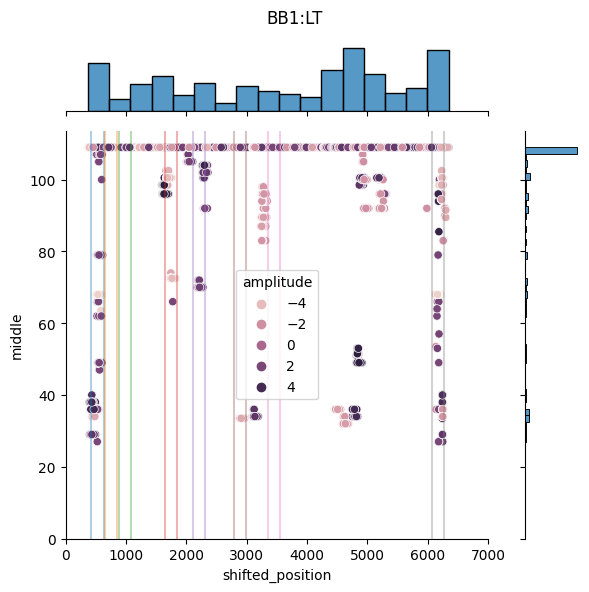

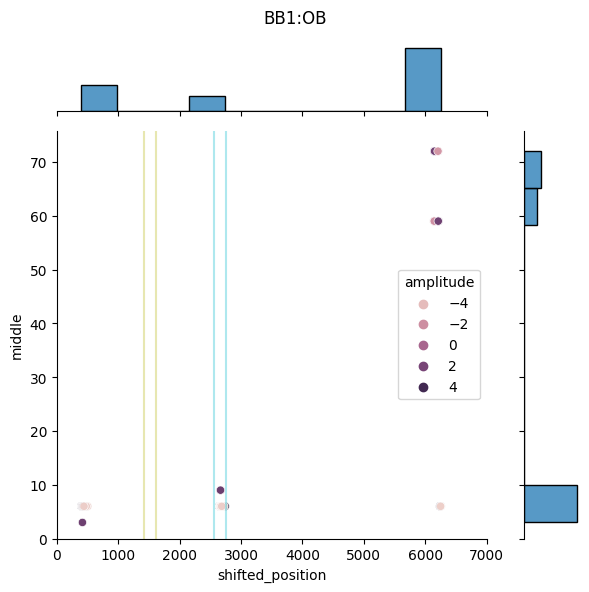

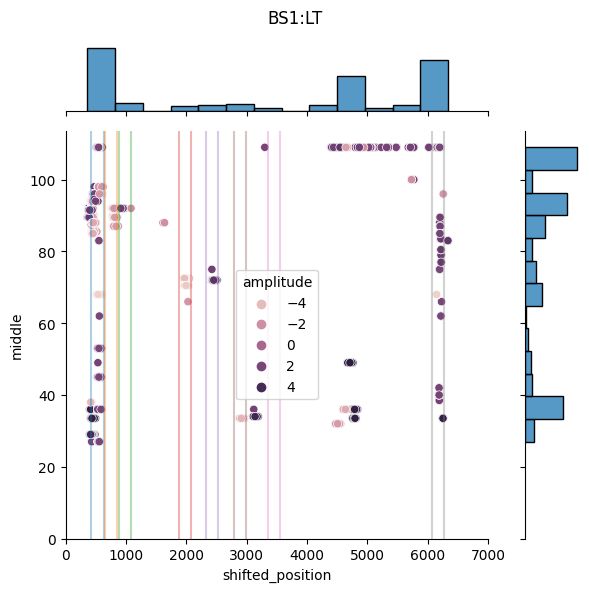

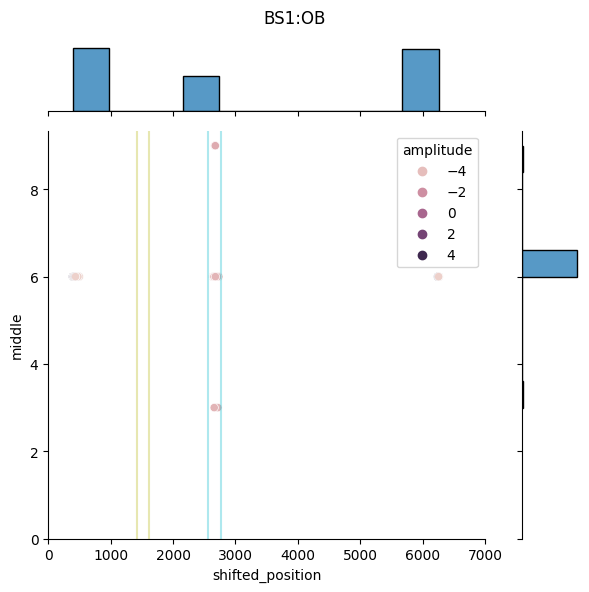

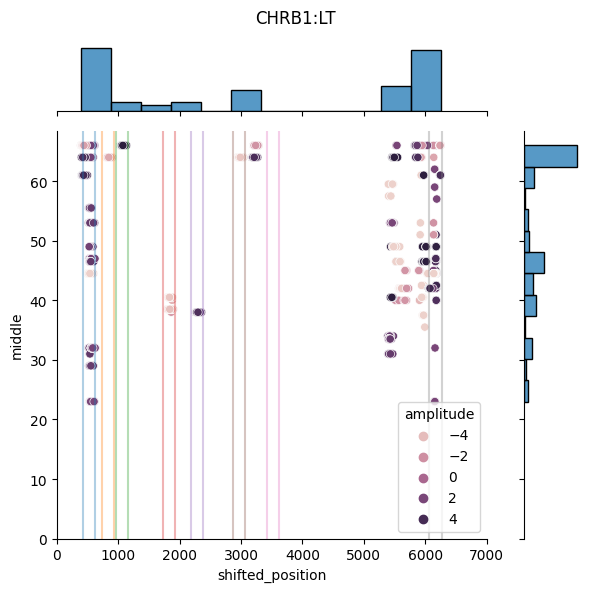

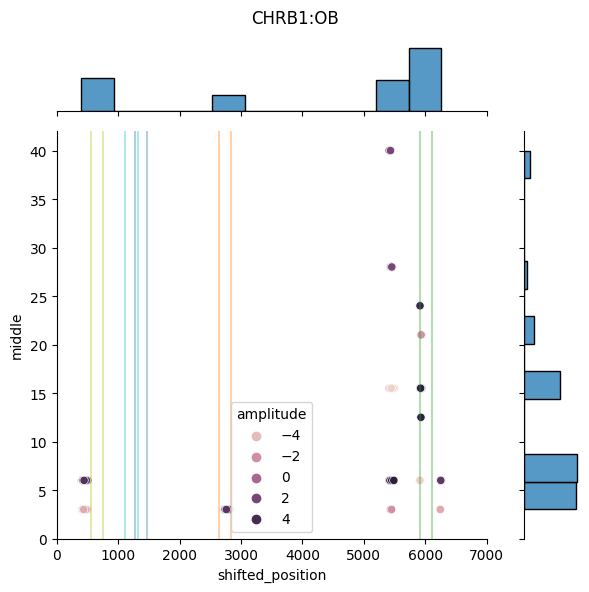

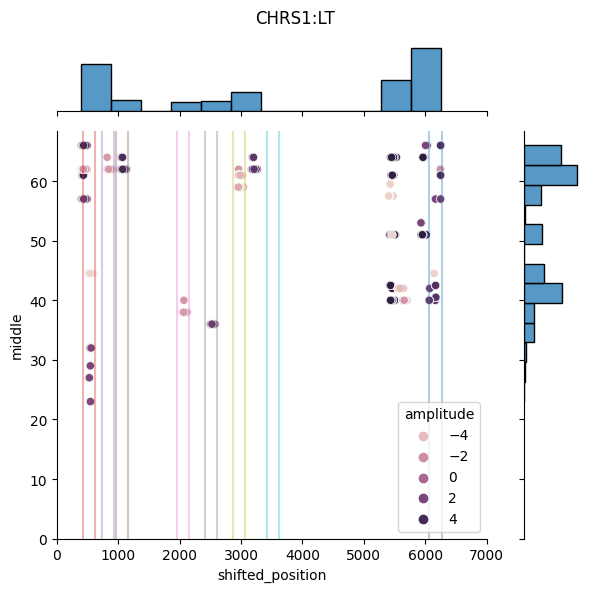

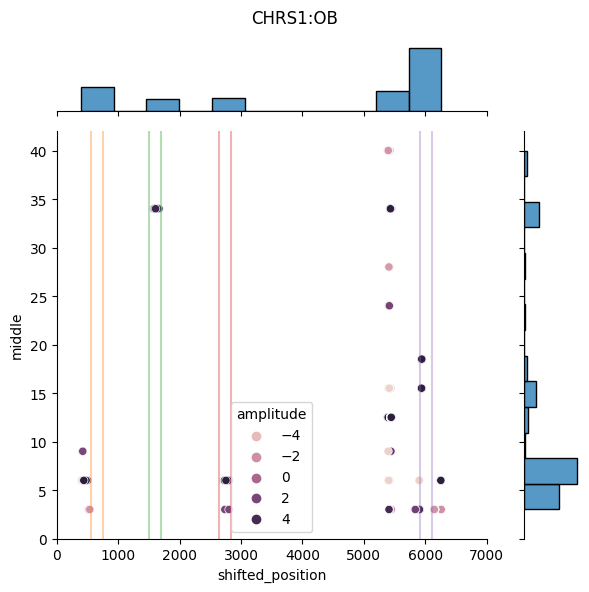

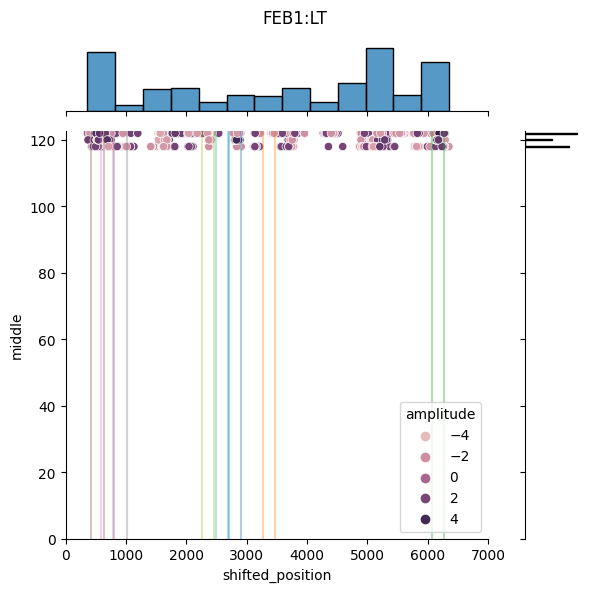

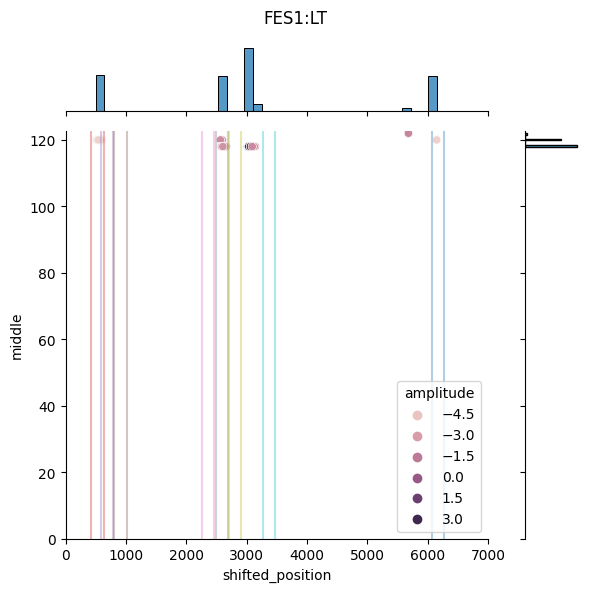

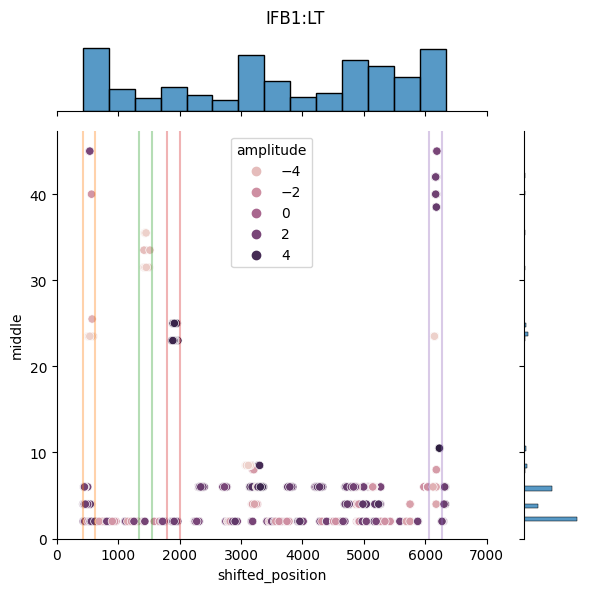

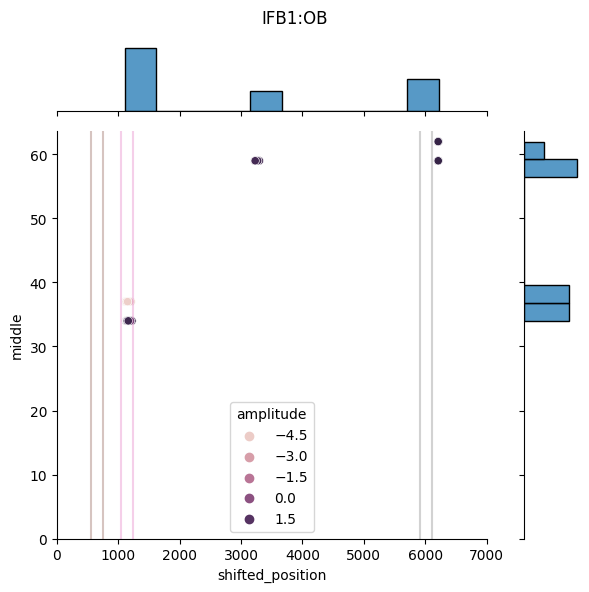

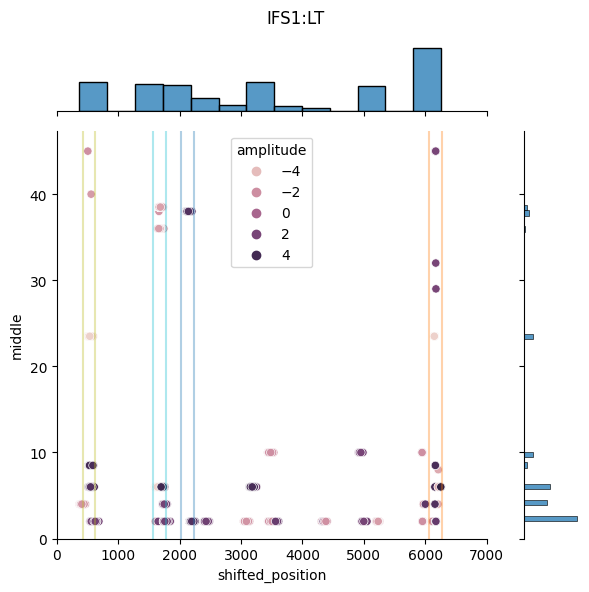

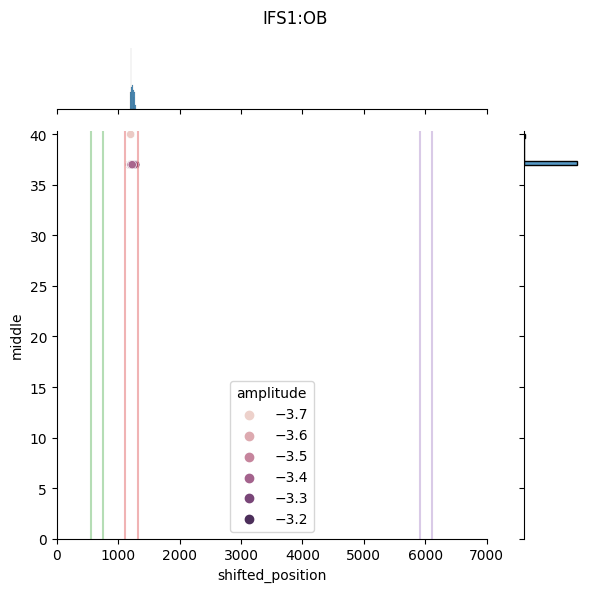

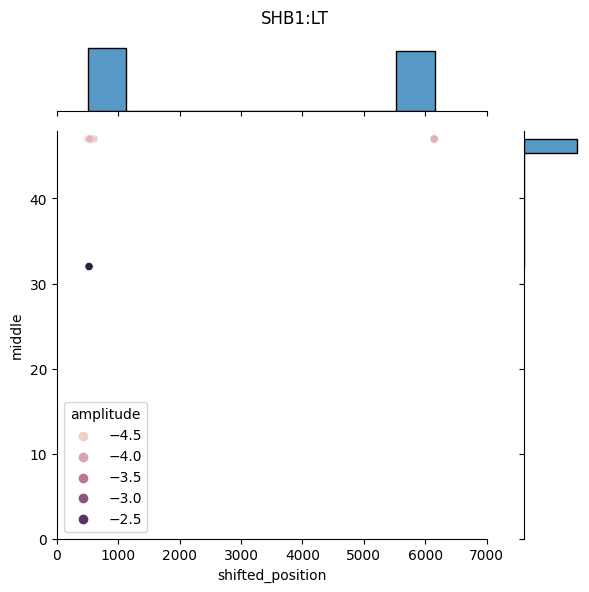

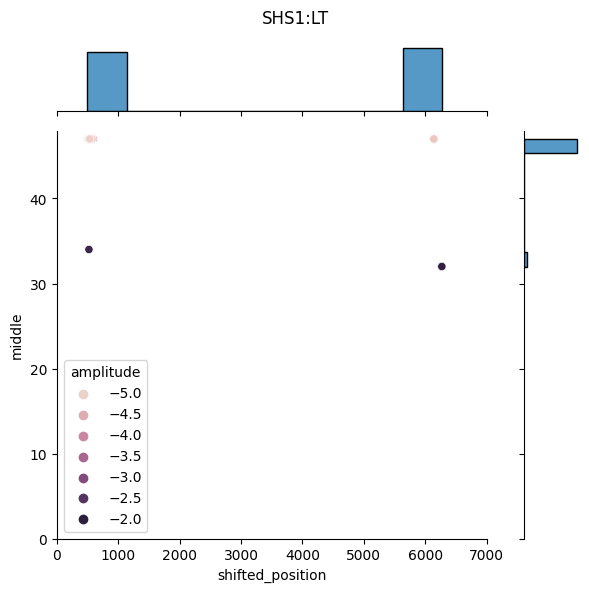

In [122]:
# color cycler from https://stackoverflow.com/questions/28430385/seaborn-cycle-through-colours-with-matplotlib-scatter
from itertools import cycle
palette = cycle(sns.color_palette())

for channel, df in defects_2d_ec.groupby('channel_name'):
    # Set defaults
    df = df.reset_index()
    x='shifted_position'
    y='middle'
    hue='batch'
    
    g = sns.JointGrid() # Create the joint plot
    # plot x y data as main data
    sns.scatterplot(
        data=df, 
        x=x, 
        y=y, 
        hue='amplitude', 
        ax=g.ax_joint
    )
    try:
        targets = target_locations.loc[channel, ['pre', 'post']]
        for idx, target in targets.iterrows():
            color=next(palette)
            g.ax_joint.axvline(target['pre'], alpha=.35, color=color)
            g.ax_joint.axvline(target['post'], alpha=.35, color=color)
    except KeyError:
        print(f'Channel {channel} not found in target list')

    sns.histplot(
        data=df, 
        x=x, 
        #hue=hue, 
        multiple='stack', 
        legend=False,
        ax=g.ax_marg_x,
    )
    sns.histplot(
        data=df,
        y=y,
        #hue=hue,
        multiple='stack',
        legend=False,
        ax=g.ax_marg_y,
    )

    #g.plot(sns.scatterplot, sns.histplot)
    g.ax_joint.set_xlim((0,7000))
    ymax = g.ax_joint.get_ylim()[1]
    g.ax_joint.set_ylim(ymin=0, ymax=ymax*1.005)
    g.figure.suptitle(f'{channel}')
    g.figure.tight_layout()

Identical to the ultrasonic data, the next objective is to determine which targets were not found in each test run. To begin, I set both the defect list and the target list to the same indices, i.e. channel and target id. For each piece, I left join the target list to the defect list. If there is an index in the target list which is not in the defect list, it is filled with a count of zero. I use groupby to condense the the defect list with an additional dimension of the index_id to look at each piece individually. 

In [124]:
# Group defects by channel, location and piece. Count defect instances
defects_2d_ec_counts = (
    defects_2d_ec_classified
    .dropna()
    .reset_index(level='db_index')
    .rename(columns={'channel_name': 'channel'})
    .groupby(
        ['db_index', 'channel', 'target_id']
    )
    ['amplitude']
    .count()
    .rename('count')
    .to_frame()
)
defects_2d_ec_counts

count
db_index channel target_id       
248      BB1:LT  21.0           2
                 150.0          2
                 177.0          2
                 195.0          4
                 225.0          4
...                           ...
3392     IFS1:LT 21.0           4
                 180.0          2
                 198.0          8
                 243.0          2
         IFS1:OB 216.0          1

[3897 rows x 1 columns]

In [125]:
# Group targets by channel and location
ec_targets = (
    target_locations
    .loc[
        target_locations['inspection_equipment'] == 'EC'
        , 'axial_location'
    ]
    .rename('target_id')
    .droplevel(-1)
    .reset_index()
)
ec_targets['count'] = 0
ec_targets = ec_targets.set_index(['channel', 'target_id'])
ec_targets.head()

count
channel target_id       
:OB     226.5          0
        213.0          0
BB1:LT  243.0          0
        234.0          0
        225.0          0

In [130]:
# Iterate over all of the pieces
# Define the piece list
db_indexes = (
    defects_2d_ec_counts
    .index
    .get_level_values('db_index')
    .unique()
)

# Iterate and combine. Using update to overlay defect list over targets
rails = []
for rail in db_indexes:
    df = ec_targets.copy()
    df.update(defects_2d_ec_counts.loc[rail])
    rails.append(df)

ec_counts = pd.concat(rails, keys=db_indexes)
ec_counts.head(10)

count
db_index channel target_id       
248      :OB     226.5        0.0
                 213.0        0.0
         BB1:LT  243.0        9.0
                 234.0        2.0
                 225.0        4.0
                 195.0        4.0
                 177.0        2.0
                 150.0        2.0
                 128.0        0.0
                 21.0         2.0

With all of the values combined, I can find the zero counts. These are the combinations which were not found for each channel, location and piece combination. 

For EC data, the channel ':OB' was not defined by supplier as being tied to specific channel, although it was on the print. It doesn't to any data so it will also be dropped. 

In [132]:
ec_misses = ec_counts[ec_counts['count'] == 0]
ec_misses = ec_misses[
    ec_misses.index.get_level_values('channel') != ':OB'
]
ec_misses

count
db_index channel  target_id       
248      BB1:LT   128.0        0.0
         BB1:OB   204.0        0.0
         BS1:LT   128.0        0.0
         BS1:OB   204.0        0.0
         CHRB1:LT 125.0        0.0
...                            ...
3392     FES1:LT  131.0        0.0
         IFB1:OB  238.0        0.0
                  27.0         0.0
         IFS1:OB  238.0        0.0
                  27.0         0.0

[1503 rows x 1 columns]

For 72 pieces, and 77 UT targets there were 1503 misses. 27% of possible combinations were not found. I will look at how much each target was missed to see if there are any patterns. I suspect that some of the targets may not be in the per-print locations.

In [134]:
ec_miss_counts = ec_misses.groupby(['channel', 'target_id'])['count'].count()
ec_miss_counts

channel   target_id
BB1:LT    128.0        35
          225.0        19
          234.0         4
BB1:OB    204.0        72
BS1:LT    128.0        72
          225.0         5
          234.0         1
BS1:OB    204.0        72
CHRB1:LT  125.0        72
CHRB1:OB  210.0        72
          216.0        72
          238.0        72
CHRS1:LT  125.0        72
CHRS1:OB  238.0        72
FEB1:LT   131.0        25
          162.0        71
          171.0         1
          228.0        46
FES1:LT   131.0        72
          153.0        72
          171.0        72
          228.0        72
          237.0        68
          243.0         4
IFB1:OB   27.0         72
          238.0        72
IFS1:OB   27.0         72
          238.0        72
Name: count, dtype: int64

There are many targets which were not identified on any of the test runs. I'll print them out but will exclude them from future review. The company is likely trying to improve sensitivity. One target was missed by all test runs but one. This likely is a false positive, so a 95% confidence was added to the exclusion listing.

In [135]:
ec_always_miss = (
    ec_miss_counts
    [ec_miss_counts > 0.95 * len(db_indexes)]
    .index
    .unique()
    #.to_frame()
)
ec_always_miss


MultiIndex([(  'BB1:OB', 204.0),
            (  'BS1:LT', 128.0),
            (  'BS1:OB', 204.0),
            ('CHRB1:LT', 125.0),
            ('CHRB1:OB', 210.0),
            ('CHRB1:OB', 216.0),
            ('CHRB1:OB', 238.0),
            ('CHRS1:LT', 125.0),
            ('CHRS1:OB', 238.0),
            ( 'FEB1:LT', 162.0),
            ( 'FES1:LT', 131.0),
            ( 'FES1:LT', 153.0),
            ( 'FES1:LT', 171.0),
            ( 'FES1:LT', 228.0),
            ( 'IFB1:OB',  27.0),
            ( 'IFB1:OB', 238.0),
            ( 'IFS1:OB',  27.0),
            ( 'IFS1:OB', 238.0)],
           names=['channel', 'target_id'])

Reprocessing the miss counts excluding the always misses allows me to see how often the remaining targets are missed. If it isn't on the list, it was always found.

In [136]:
ec_miss_counts = ec_miss_counts[ec_miss_counts < 0.95 * len(db_indexes)]
miss_rate = ec_miss_counts/len(db_indexes)
miss_rate

channel  target_id
BB1:LT   128.0        0.486111
         225.0        0.263889
         234.0        0.055556
BS1:LT   225.0        0.069444
         234.0        0.013889
FEB1:LT  131.0        0.347222
         171.0        0.013889
         228.0        0.638889
FES1:LT  237.0        0.944444
         243.0        0.055556
Name: count, dtype: float64

The final processed list identifies misses by each piece, channel, location. This excludes the "always miss" targets. This final data is what would be uploaded to the production database for certification review for each pass. 

In [137]:
(
    ec_counts
    .reset_index('db_index')
    .loc[
        ~ec_counts.reset_index('db_index').index.isin(ec_always_miss) &
        (ec_counts['count'] == 0).to_numpy() &
        (ec_counts.index.get_level_values('channel') != ':OB'),
        'db_index'
    ]
    .reset_index()
    .set_index('db_index')
)

,channel,target_id
db_index,,
248,BB1:LT,128.0
248,FEB1:LT,228.0
248,FES1:LT,237.0
249,BB1:LT,225.0
249,BB1:LT,128.0
...,...,...
3390,BS1:LT,225.0
3390,FES1:LT,237.0
3391,FEB1:LT,228.0


# Upload SQL Data Structure
To avoid API calls from the the reporting and transactional servers, to the production equipment, the best streamlining solution is to reformat and replicate the data on the reporting and transactional servers. Below is a listing of table structures used to develop database diagrams using https://dbdiagrams.io. Although they are all listed together, there are two major sections, transactional data and reporting data. The syntax used to describe the database can be easily translated into an SQL create statement because the table name, field name, primary keys, foreign keys, and data types are all included. 

## Transactional Data
The transactional data compliments the tracking system requirements. The tracking system monitors a piece's movement through the manufacturing process, and records necessary identifying information, such as piece characteristics and status. 

![Transaction Database Diagram](dbdiagram_L2_upload.png)

The core tables are `ndt_curves` and `ndt_pieces`. These tables are consolidations of several API calls to the equipment server. The ndt_index stored in the same records as the rail_id is a key link. Most transactional queries require one of these two identifiers; the ndt_index for ndt related data, and the rail_id for traceability transactions outside the scope of this project. The majority of other tables are identification information using normal forms. 

## Reporting data
For the validation of the calibration system, a reporting structure is more suitable. At this time the results of a single test is most important, so the amount of multi-dimensionally data is not extensive. I did add in a date dimension table because we may want to track both targets missing and found over time. 

![Reporting Database Diagram](dbdiagram_reporting.png)

By trying to run a reporting system inside of the transactional system, remnants of the normalized tables structures are still present.

# Conclusion
The purpose of this project was to extract and analyze non-destructive testing results from an example database. Functions were developed to extract scan and defect data from a vendor provided API. For a calibration piece, target details (location, shape and sensor/channel) were translated from engineering prints to a useable tabular format. Classification of defects based on where they were found relative to intended locations. Determination of targets which were not identified were logged for each piece run. The algorithms developed in this project can be quickly incorporated into the final production system to perform analysis for calibration run.

Table level modifications to the transactional database were identified, and diagrammed to support uploading of the data previously discussed. 

Overall, this project was successful as it accomplished the initial target goals. The analysis performed and structures generated in this project will be useful for installation and calibrations being performed in the fall of 2023.